# Bioinformatic - Pipeline Comparison for BLG 604E

## OUTLINE

#### PART A) RESULTS FROM THE PIPELINES
1- Reading SNP vcf filenames generated as a result of the pipeline.
<br> 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

#### PART B) RESULTS OF THE LL VALIDATED VCFS
1- Reading ll validated vcfs.
<br> 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

#### PART C) SET OPERATIONS
1- Creating a set operations funtions. 
<br>2- Creating a intersection array from each sets. 
<br>3- Show Intersection Results in heatmap

#### PART D) COMPARISON WITH UNION VALIDATED VCF'S
1- Create an union of all ll validated vfc sets for each data.
<br>2- Show results in heatmap.

#### PART E) OPENCRAVAT DATA
1- 

## ABOUT DATA
50-51 : LL DATA
<br>44-45 : NC DATA
<br>79-80 : FD1 DATA
<br>74-83 : Il_1 DATA
<br>18-19 : EA DATA
<br> 47-52: NV DATA

## IMPORT SECTION

In [1]:
import os
import allel
import numpy as np # pip3 install matplotlib
import matplotlib.pyplot as plt # pip3 install matplotlib

import random
import community # can be installed with: "pip install python-louvain"
from numpy import linalg as LA
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import math
import scipy.io as sio
from skimage import data, segmentation, color
from skimage.future import graph
from sklearn.preprocessing import MinMaxScaler

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

### Common Funtions

In [3]:
#Deleting indels from VCF
def remove_indels(t):
    t = t[t["REF"].apply(len) == 1 ]
    t = t[t["ALT_1"].apply(len) == 1]
    return t 

#Normalization
def normalization(df):
    return MinMaxScaler().fit_transform(np.array(df['Results']).reshape(-1,1))

#Apply Filters
def filtersControl(key,df):
    df = df.copy()
    
    #Getting variantCaller Name
    VCName = key.split('/')
    
    #Apply Filter Pass if not somaticSniper
    df = df if VCName[len(VCName)-1] == 'somaticSniper' else df[df["FILTER_PASS"]]
    
    #SOMATIC filter on strelka
    df = df[df['SOMATIC'].astype("bool")] if VCName[len(VCName)-1] == 'strelka' else df
        
    return df

## PART A) RESULTS FROM THE PIPELINES

### 1- Reading SNP vcf filenames generated as a result of the pipeline.

In [4]:
snp_filenames = {}
for root, directories, filenames in os.walk('vcf/snp'):
    for fn in filenames:
        if fn == '.DS_Store':
            continue;
        else:
            snp_filenames[root[8:]] = os.path.join(root,fn)

In [5]:
len(snp_filenames)

36

### 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

In [6]:
sets_dict = {}

filtering_df = pd.DataFrame(columns=["Key", "Total Length", "After FilterPass", "After RemoveIndels"])

for key in tqdm(snp_filenames):
    
    #Creating a dataframe for each vcf.
    temp = allel.vcf_to_dataframe(snp_filenames[key],fields='variants/*')
    #print(key)
    #display(temp.head())
    #Filtering - STARTS
    total_len = len(temp)
    temp = filtersControl(key,temp) #FilterPass control for somaticSniper
    after_Filterpass_len = len(temp)
    temp = remove_indels(temp) 
    without_indels_len = len(temp)
    #temp = temp[temp["CHROM"].apply(lambda x: "_" in x)]
    #Filtering - ENDS
    
    #For printing changes in the vcf lengths
    filtering_df.loc[len(filtering_df.index)] = [key , total_len, after_Filterpass_len,without_indels_len]
    
    #Creating a dictionary for each set
    if len(temp) != 0:
        sets_dict[key]= set(temp[["CHROM","POS","REF","ALT_1"]].apply(lambda row: "_".join(map(str, row)), axis=1))

100%|███████████████████████████████████████████| 36/36 [00:17<00:00,  2.09it/s]


In [7]:
snp_filenames

{'FD1/bowtie/somaticSniper': 'vcf/snp/FD1/bowtie/somaticSniper/snp_SRR7890880_bowtie-SRR7890879_bowtie_somaticsniper.vcf.SNPfilter',
 'FD1/bowtie/strelka': 'vcf/snp/FD1/bowtie/strelka/snp_SRR7890880_bowtie-SRR7890879_bowtie_strelka.vcf',
 'FD1/bowtie/mutect': 'vcf/snp/FD1/bowtie/mutect/snp_SRR7890880_bowtie-SRR7890879_bowtie_mutect.vcf',
 'FD1/bwa2/somaticSniper': 'vcf/snp/FD1/bwa2/somaticSniper/snp_SRR7890880_bwa2-SRR7890879_bwa2_somaticsniper.vcf.SNPfilter',
 'FD1/bwa2/strelka': 'vcf/snp/FD1/bwa2/strelka/snp_SRR7890880_bwa2-SRR7890879_bwa2_strelka.vcf',
 'FD1/bwa2/mutect': 'vcf/snp/FD1/bwa2/mutect/snp_SRR7890880_bwa2-SRR7890879_bwa2_mutect.vcf',
 'IL1/bowtie/somaticSniper': 'vcf/snp/IL1/bowtie/somaticSniper/snp_SRR7890874_bowtie-SRR7890883_bowtie_somaticsniper.vcf.SNPfilter',
 'IL1/bowtie/strelka': 'vcf/snp/IL1/bowtie/strelka/snp_SRR7890874_bowtie-SRR7890883_bowtie_strelka.vcf',
 'IL1/bowtie/mutect': 'vcf/snp/IL1/bowtie/mutect/snp_SRR7890874_bowtie-SRR7890883_bowtie_mutect.vcf',
 'IL

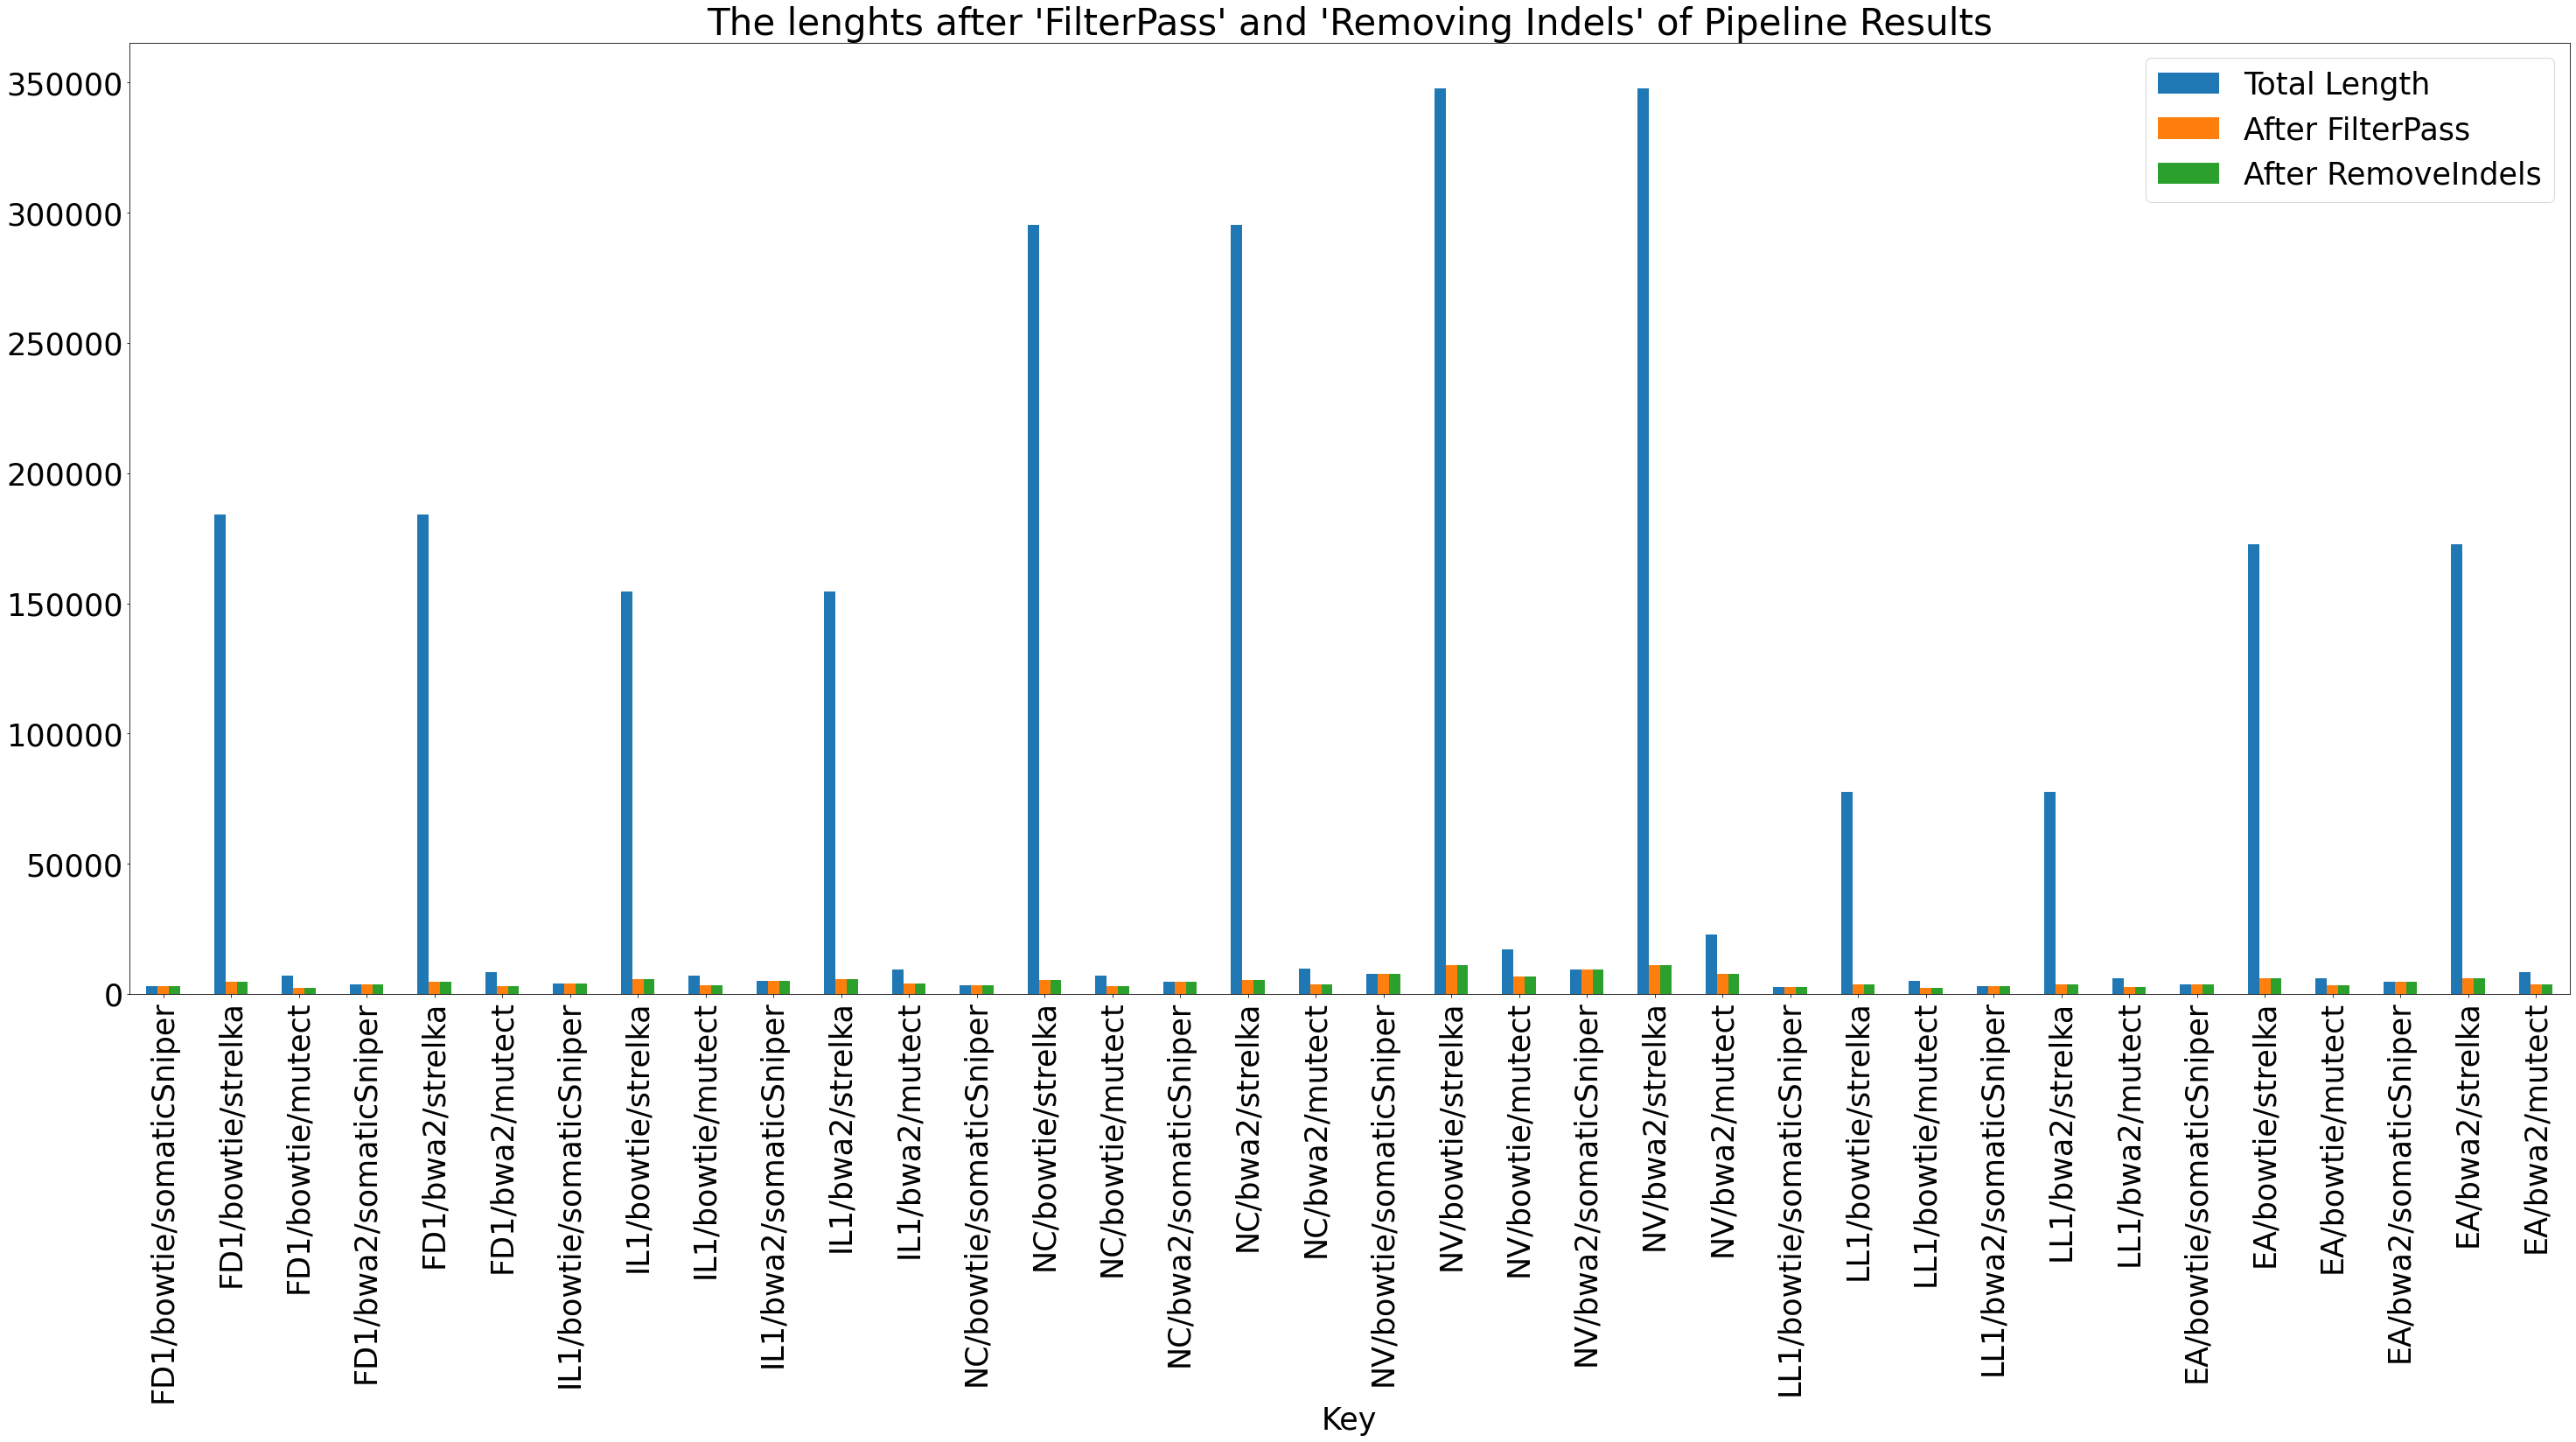

In [8]:
#Example
#len(sets_dict)
#len(sets_dict['50_51/bowtie/octopus'])
plt.rcParams.update({'font.size': 35}) # must set in top
ax = filtering_df.plot('Key',kind='bar',title="The lenghts after 'FilterPass' and 'Removing Indels' of Pipeline Results",figsize=(50,20))
for p in ax.patches:
    if p.get_height() == 0:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## PART B) RESULTS OF THE LL VALIDATED VCFS

### 1- Reading ll validated vcfs.

In [9]:
ll_filenames = {}
for root, directories, filenames in os.walk('vcf/validated_vcfs'):
    for fn in filenames:
        if fn == '.DS_Store':
            continue;
        else:
            ll_filenames[root[19:]] = os.path.join(root,fn)

In [10]:
len(ll_filenames)

54

### 2- Creating a set for each dataframe with using "CHROM","POS","REF","ALT_1" columns.

In [11]:
ll_sets_dict = {}

ll_filtering_df = pd.DataFrame(columns=["Key", "Total Length", "After FilterPass", "After RemoveIndels"])

for key in tqdm(ll_filenames):
    #Creating a dataframe for each vcf.
    temp = allel.vcf_to_dataframe(ll_filenames[key],fields='variants/*')
    
    #Filtering - STARTS
    total_length = len(temp)
    temp = filtersControl(key,temp) #FilterPass control for somaticSniper
    after_filterpass = len(temp)
    temp = remove_indels(temp)
    after_remove_indels = len(temp)
    #Filtering - ENDS
    
    #For printing changes in the vcf lengths
    ll_filtering_df.loc[len(ll_filtering_df.index)] = [key , total_length, after_filterpass,after_remove_indels]

    #Creating a set for each dataframe
    if len(temp) != 0 :
        ll_sets_dict[key]= set(temp[["CHROM","POS","REF","ALT_1"]].apply(lambda row: "_".join(map(str, row)), axis=1))

100%|███████████████████████████████████████████| 54/54 [00:13<00:00,  3.92it/s]


In [12]:
key

'EA/bowtie/mutect'

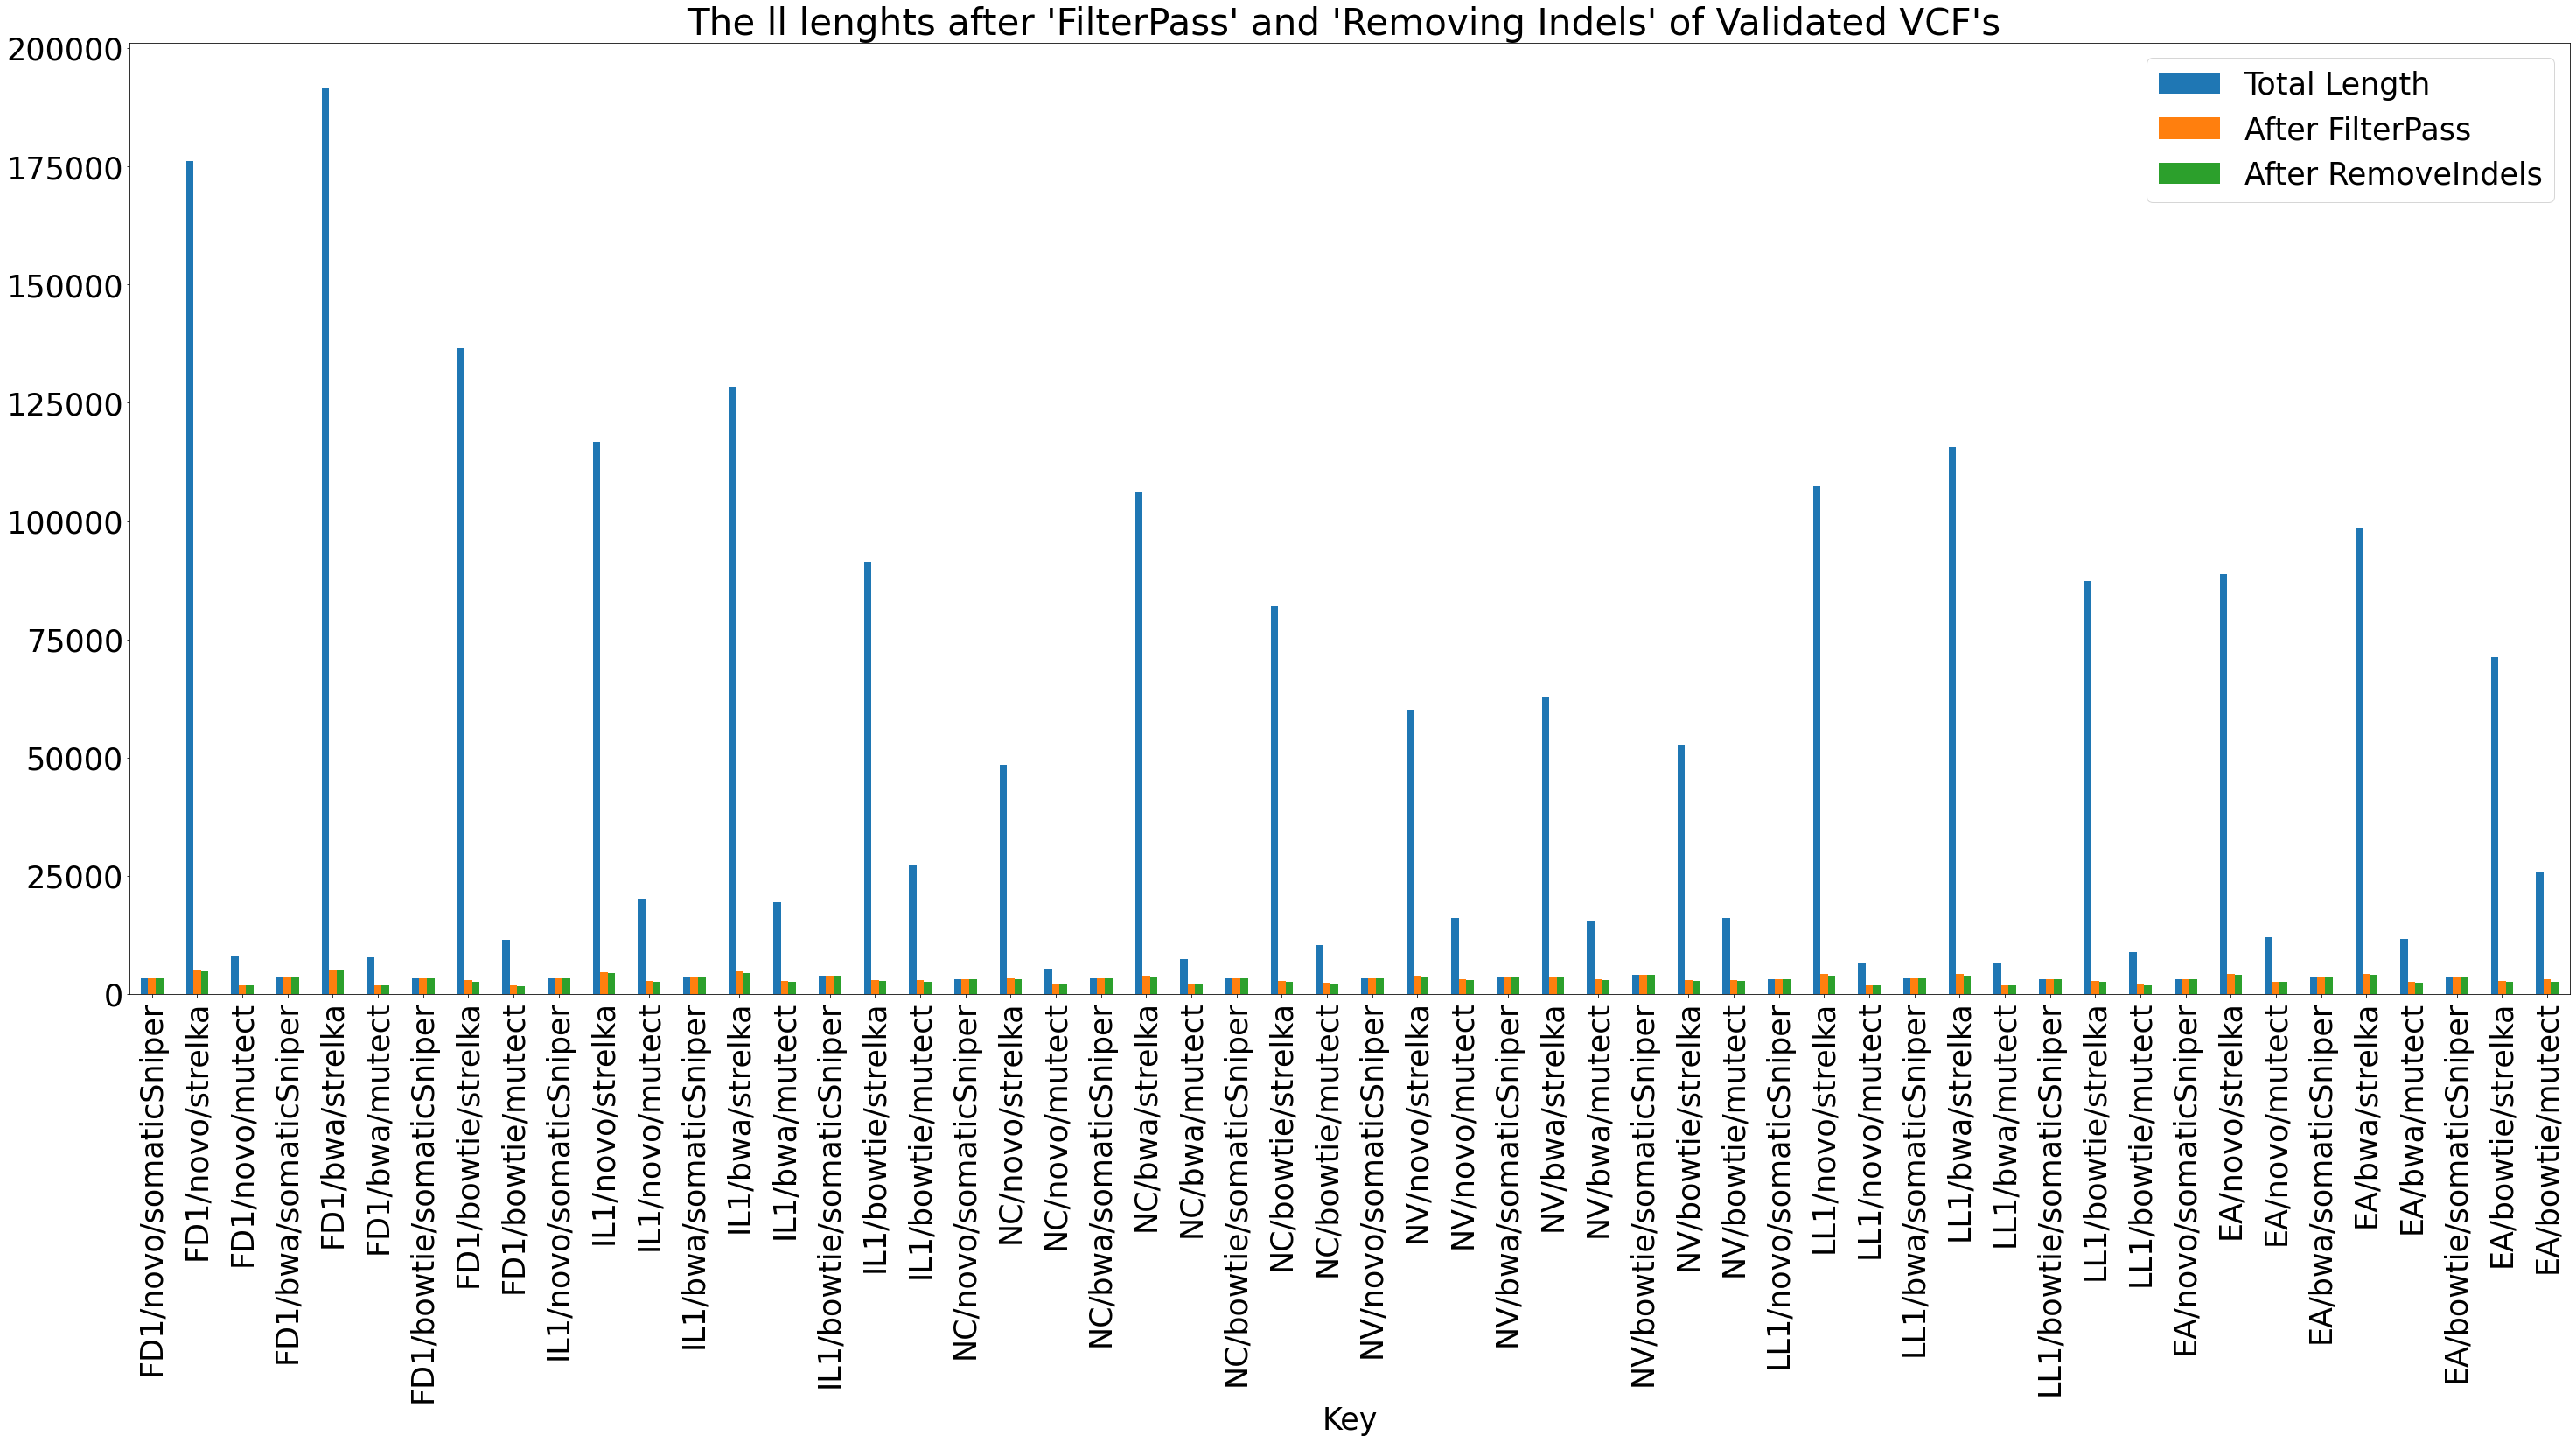

In [13]:
plt.rcParams.update({'font.size': 35}) # must set in top
ax = ll_filtering_df.plot('Key',kind='bar',title="The ll lenghts after 'FilterPass' and 'Removing Indels' of Validated VCF's ",figsize=(50,20))
for p in ax.patches:
    if p.get_height() == 0:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## PART C) SET OPERATIONS


### 1- Creating a set operations funtions.

In [14]:
#The intersection of two sets is the set of all the common elements of both the sets. 
def intersec(s1,s2):
    return len(s1.intersection(s2))

#The union of two sets is the set of all the elements of both the sets without duplicates.
def uni(s1,s2):
    return len(s1.union(s2))

#The difference between two sets is the set of all the elements in first set that are not present in the second set. 
def dif(s1,s2):
    return len(s1.difference(s2))

#Jaccard Similarity function for two sets ( int / )
def js_set(s1, s2):
    intersection = len(list(set(s1).intersection(s2)))
    union = uni(s1,s2)
    return np.float64(round((float(intersection) / union) * 100) / 100);

### 2- Creating a intersection array from each sets. 

In [15]:
#Initializing a dataframe
df_js = pd.DataFrame(columns=["VAL_VCF", "Result_VCF", "Results"])

#Initializing a count for the rows
count = 0

#Computing each intersection of ll and the pipeline vcfs by looking at their key values. 
for key1 in tqdm(ll_sets_dict): 
    for key2 in sets_dict:
        d_temp = pd.DataFrame([[key1, key2, js_set(ll_sets_dict[key1],sets_dict[key2])]],
                   columns=['VAL_VCF', 'Result_VCF',"Results"])
        df_js = pd.concat((df_js,d_temp), ignore_index = True)
    
#Normalizing the results values with MinMaxScaler [0,1]
#df_t['Results'] = MinMaxScaler().fit_transform(np.array(df_t['Results']).reshape(-1,1))

#df_t
df_js

100%|███████████████████████████████████████████| 54/54 [00:03<00:00, 16.17it/s]


VAL_VCF                Result_VCF  Results
0     FD1/novo/somaticSniper  FD1/bowtie/somaticSniper     0.43
1     FD1/novo/somaticSniper        FD1/bowtie/strelka     0.36
2     FD1/novo/somaticSniper         FD1/bowtie/mutect     0.44
3     FD1/novo/somaticSniper    FD1/bwa2/somaticSniper     0.39
4     FD1/novo/somaticSniper          FD1/bwa2/strelka     0.36
...                      ...                       ...      ...
1939        EA/bowtie/mutect         EA/bowtie/strelka     0.27
1940        EA/bowtie/mutect          EA/bowtie/mutect     0.45
1941        EA/bowtie/mutect     EA/bwa2/somaticSniper     0.28
1942        EA/bowtie/mutect           EA/bwa2/strelka     0.27
1943        EA/bowtie/mutect            EA/bwa2/mutect     0.41

[1944 rows x 3 columns]

### 3- Show Intersection Results in heatmap

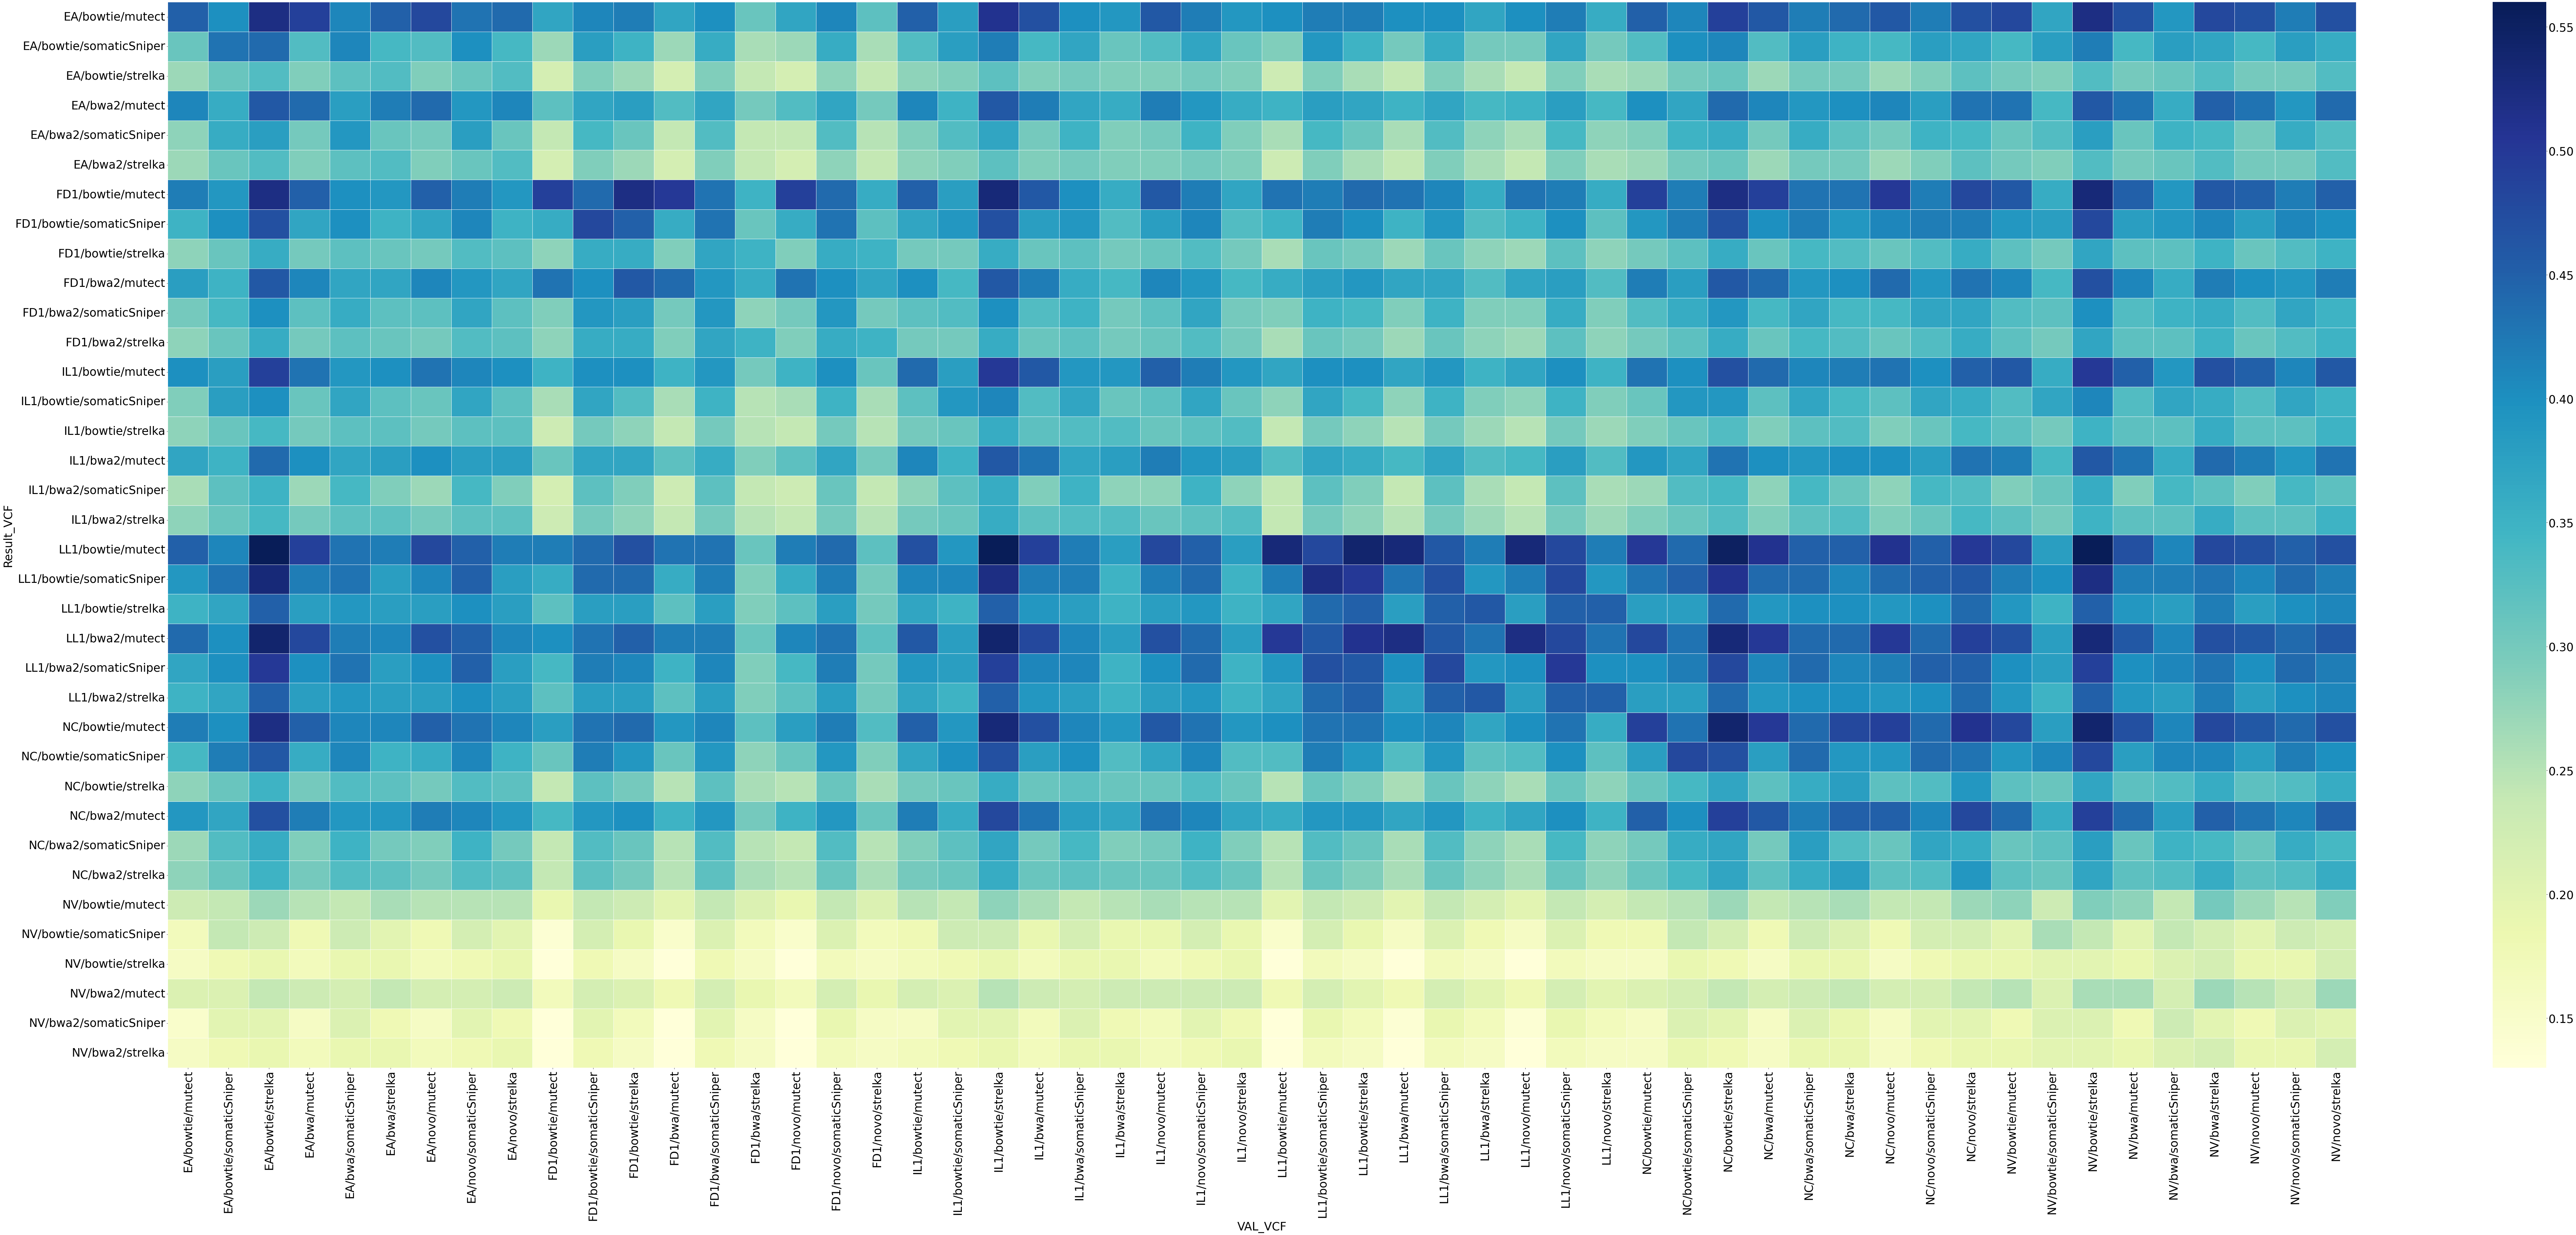

In [16]:
plt.figure(figsize = (150,60))
df_h = df_js.pivot("Result_VCF", "VAL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(df_h, annot=False, cmap="YlGnBu", linewidths=.5)

In [17]:
t_novo = []
t_bwa = []
t_bowtie = []

for index,row in df_js.iterrows():
    if row['VAL_VCF'].split('/')[1] == 'novo' and row['Result_VCF'].split('/')[1] == 'novo':
        t_novo.append(row)
    elif row['VAL_VCF'].split('/')[1] == 'bwa'and row['Result_VCF'].split('/')[1] == 'bwa2':
        t_bwa.append(row)
    elif row['VAL_VCF'].split('/')[1] == 'bowtie' and row['Result_VCF'].split('/')[1] == 'bowtie' :
        t_bowtie.append(row)

In [18]:
df_novo = pd.DataFrame(t_novo , columns=["VAL_VCF", "Result_VCF", "Results"])
df_bwa = pd.DataFrame(t_bwa, columns=["VAL_VCF", "Result_VCF", "Results"])
df_bowtie = pd.DataFrame(t_bowtie,columns=["VAL_VCF", "Result_VCF", "Results"])
df_bowtie

VAL_VCF                Result_VCF  Results
216   FD1/bowtie/somaticSniper  FD1/bowtie/somaticSniper     0.48
217   FD1/bowtie/somaticSniper        FD1/bowtie/strelka     0.36
218   FD1/bowtie/somaticSniper         FD1/bowtie/mutect     0.44
222   FD1/bowtie/somaticSniper  IL1/bowtie/somaticSniper     0.37
223   FD1/bowtie/somaticSniper        IL1/bowtie/strelka     0.30
...                        ...                       ...      ...
1933          EA/bowtie/mutect        LL1/bowtie/strelka     0.35
1934          EA/bowtie/mutect         LL1/bowtie/mutect     0.45
1938          EA/bowtie/mutect   EA/bowtie/somaticSniper     0.31
1939          EA/bowtie/mutect         EA/bowtie/strelka     0.27
1940          EA/bowtie/mutect          EA/bowtie/mutect     0.45

[324 rows x 3 columns]

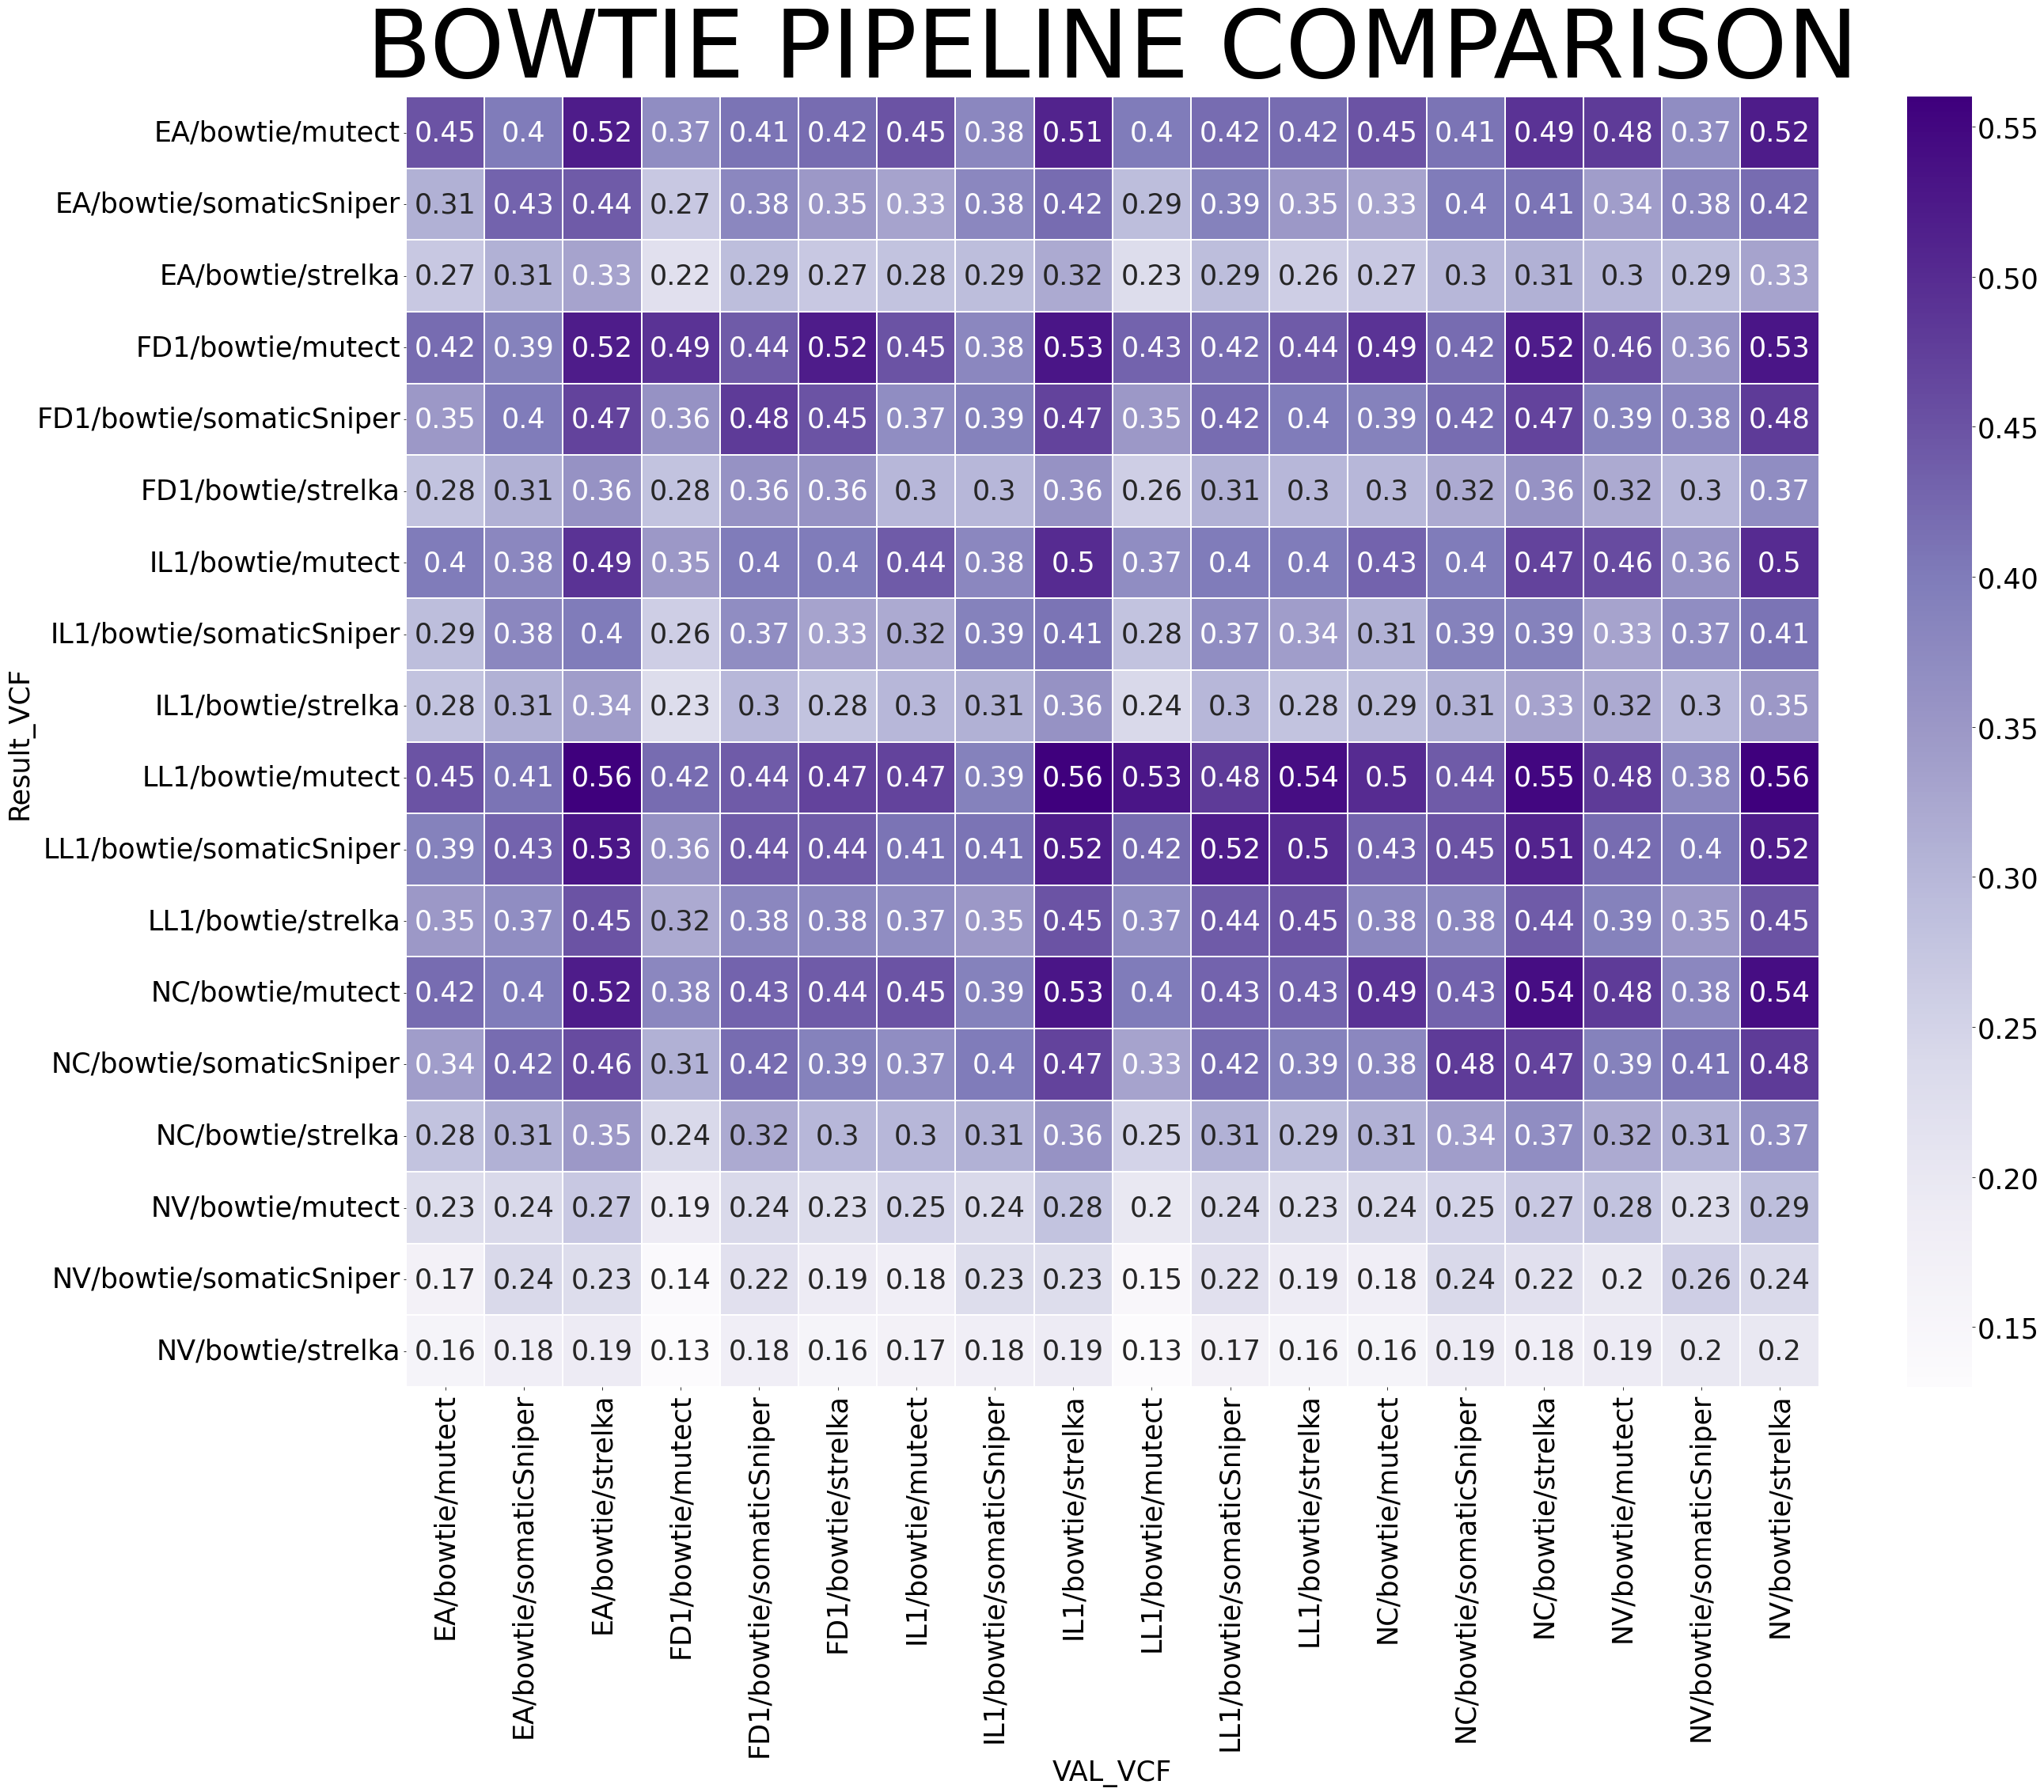

In [19]:
###BOWTIE
plt.figure(figsize = (40,30))
plt.title('BOWTIE PIPELINE COMPARISON', size = 120)
df_bowtie_h = df_bowtie.pivot("Result_VCF", "VAL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(df_bowtie_h, annot=True, cmap="Purples", linewidths=.2)

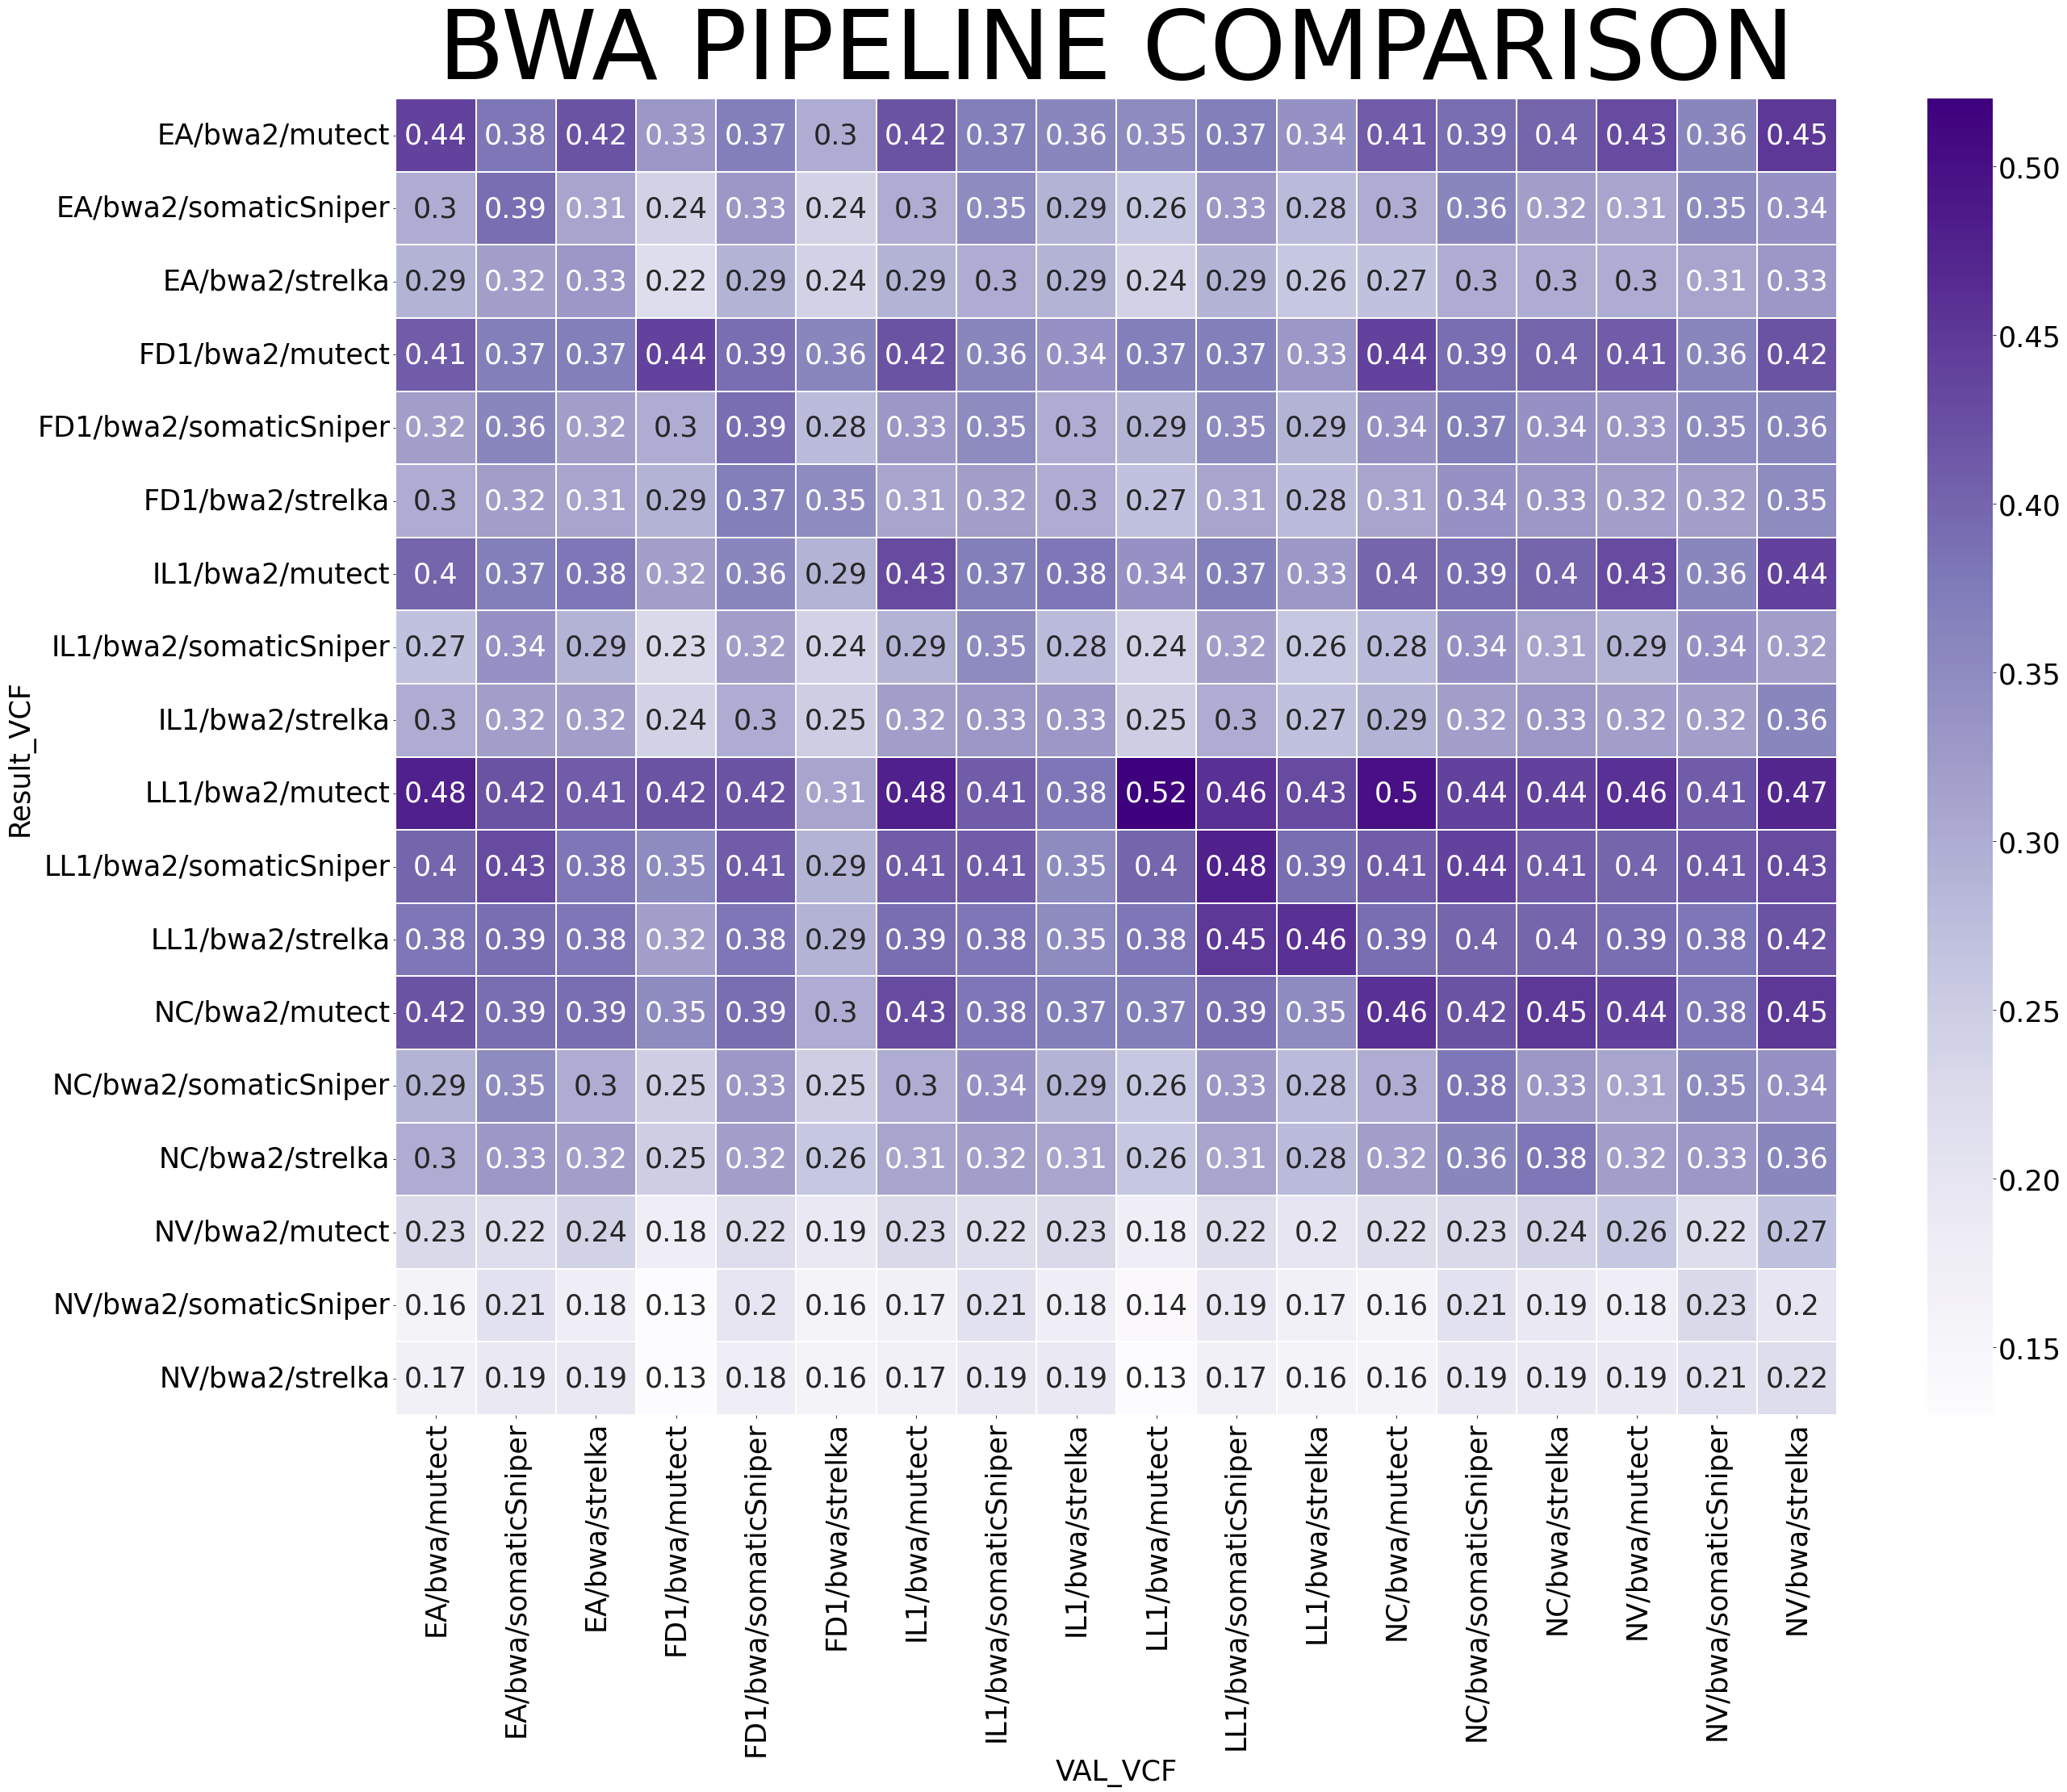

In [21]:
###BWA
plt.figure(figsize = (40,30))
plt.title('BWA PIPELINE COMPARISON', size = 120)
df_bwa_h = df_bwa.pivot("Result_VCF", "VAL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(df_bwa_h, annot=True, cmap="Purples", linewidths=.2)

### VARIANT CALLER

In [26]:
t_mutect = []
t_ss = []
t_strelka = []

for index,row in df_js.iterrows():
    if row['VAL_VCF'].split('/')[2] == 'mutect' and row['Result_VCF'].split('/')[2] == 'mutect':
        t_mutect.append(row)
    elif row['VAL_VCF'].split('/')[2] == 'somaticSniper'and row['Result_VCF'].split('/')[2] == 'somaticSniper':
        t_ss.append(row)
    elif row['VAL_VCF'].split('/')[2] == 'strelka' and row['Result_VCF'].split('/')[2] == 'strelka' :
        t_strelka.append(row)
        

In [27]:
df_mutect = pd.DataFrame(t_mutect , columns=["VAL_VCF", "Result_VCF", "Results"])
df_ss = pd.DataFrame(t_ss, columns=["VAL_VCF", "Result_VCF", "Results"])
df_strelka = pd.DataFrame(t_strelka,columns=["VAL_VCF", "Result_VCF", "Results"])
df_ss

VAL_VCF                Result_VCF  Results
0      FD1/novo/somaticSniper  FD1/bowtie/somaticSniper     0.43
3      FD1/novo/somaticSniper    FD1/bwa2/somaticSniper     0.39
6      FD1/novo/somaticSniper  IL1/bowtie/somaticSniper     0.35
9      FD1/novo/somaticSniper    IL1/bwa2/somaticSniper     0.31
12     FD1/novo/somaticSniper   NC/bowtie/somaticSniper     0.39
...                       ...                       ...      ...
1857  EA/bowtie/somaticSniper     NV/bwa2/somaticSniper     0.20
1860  EA/bowtie/somaticSniper  LL1/bowtie/somaticSniper     0.43
1863  EA/bowtie/somaticSniper    LL1/bwa2/somaticSniper     0.40
1866  EA/bowtie/somaticSniper   EA/bowtie/somaticSniper     0.43
1869  EA/bowtie/somaticSniper     EA/bwa2/somaticSniper     0.36

[216 rows x 3 columns]

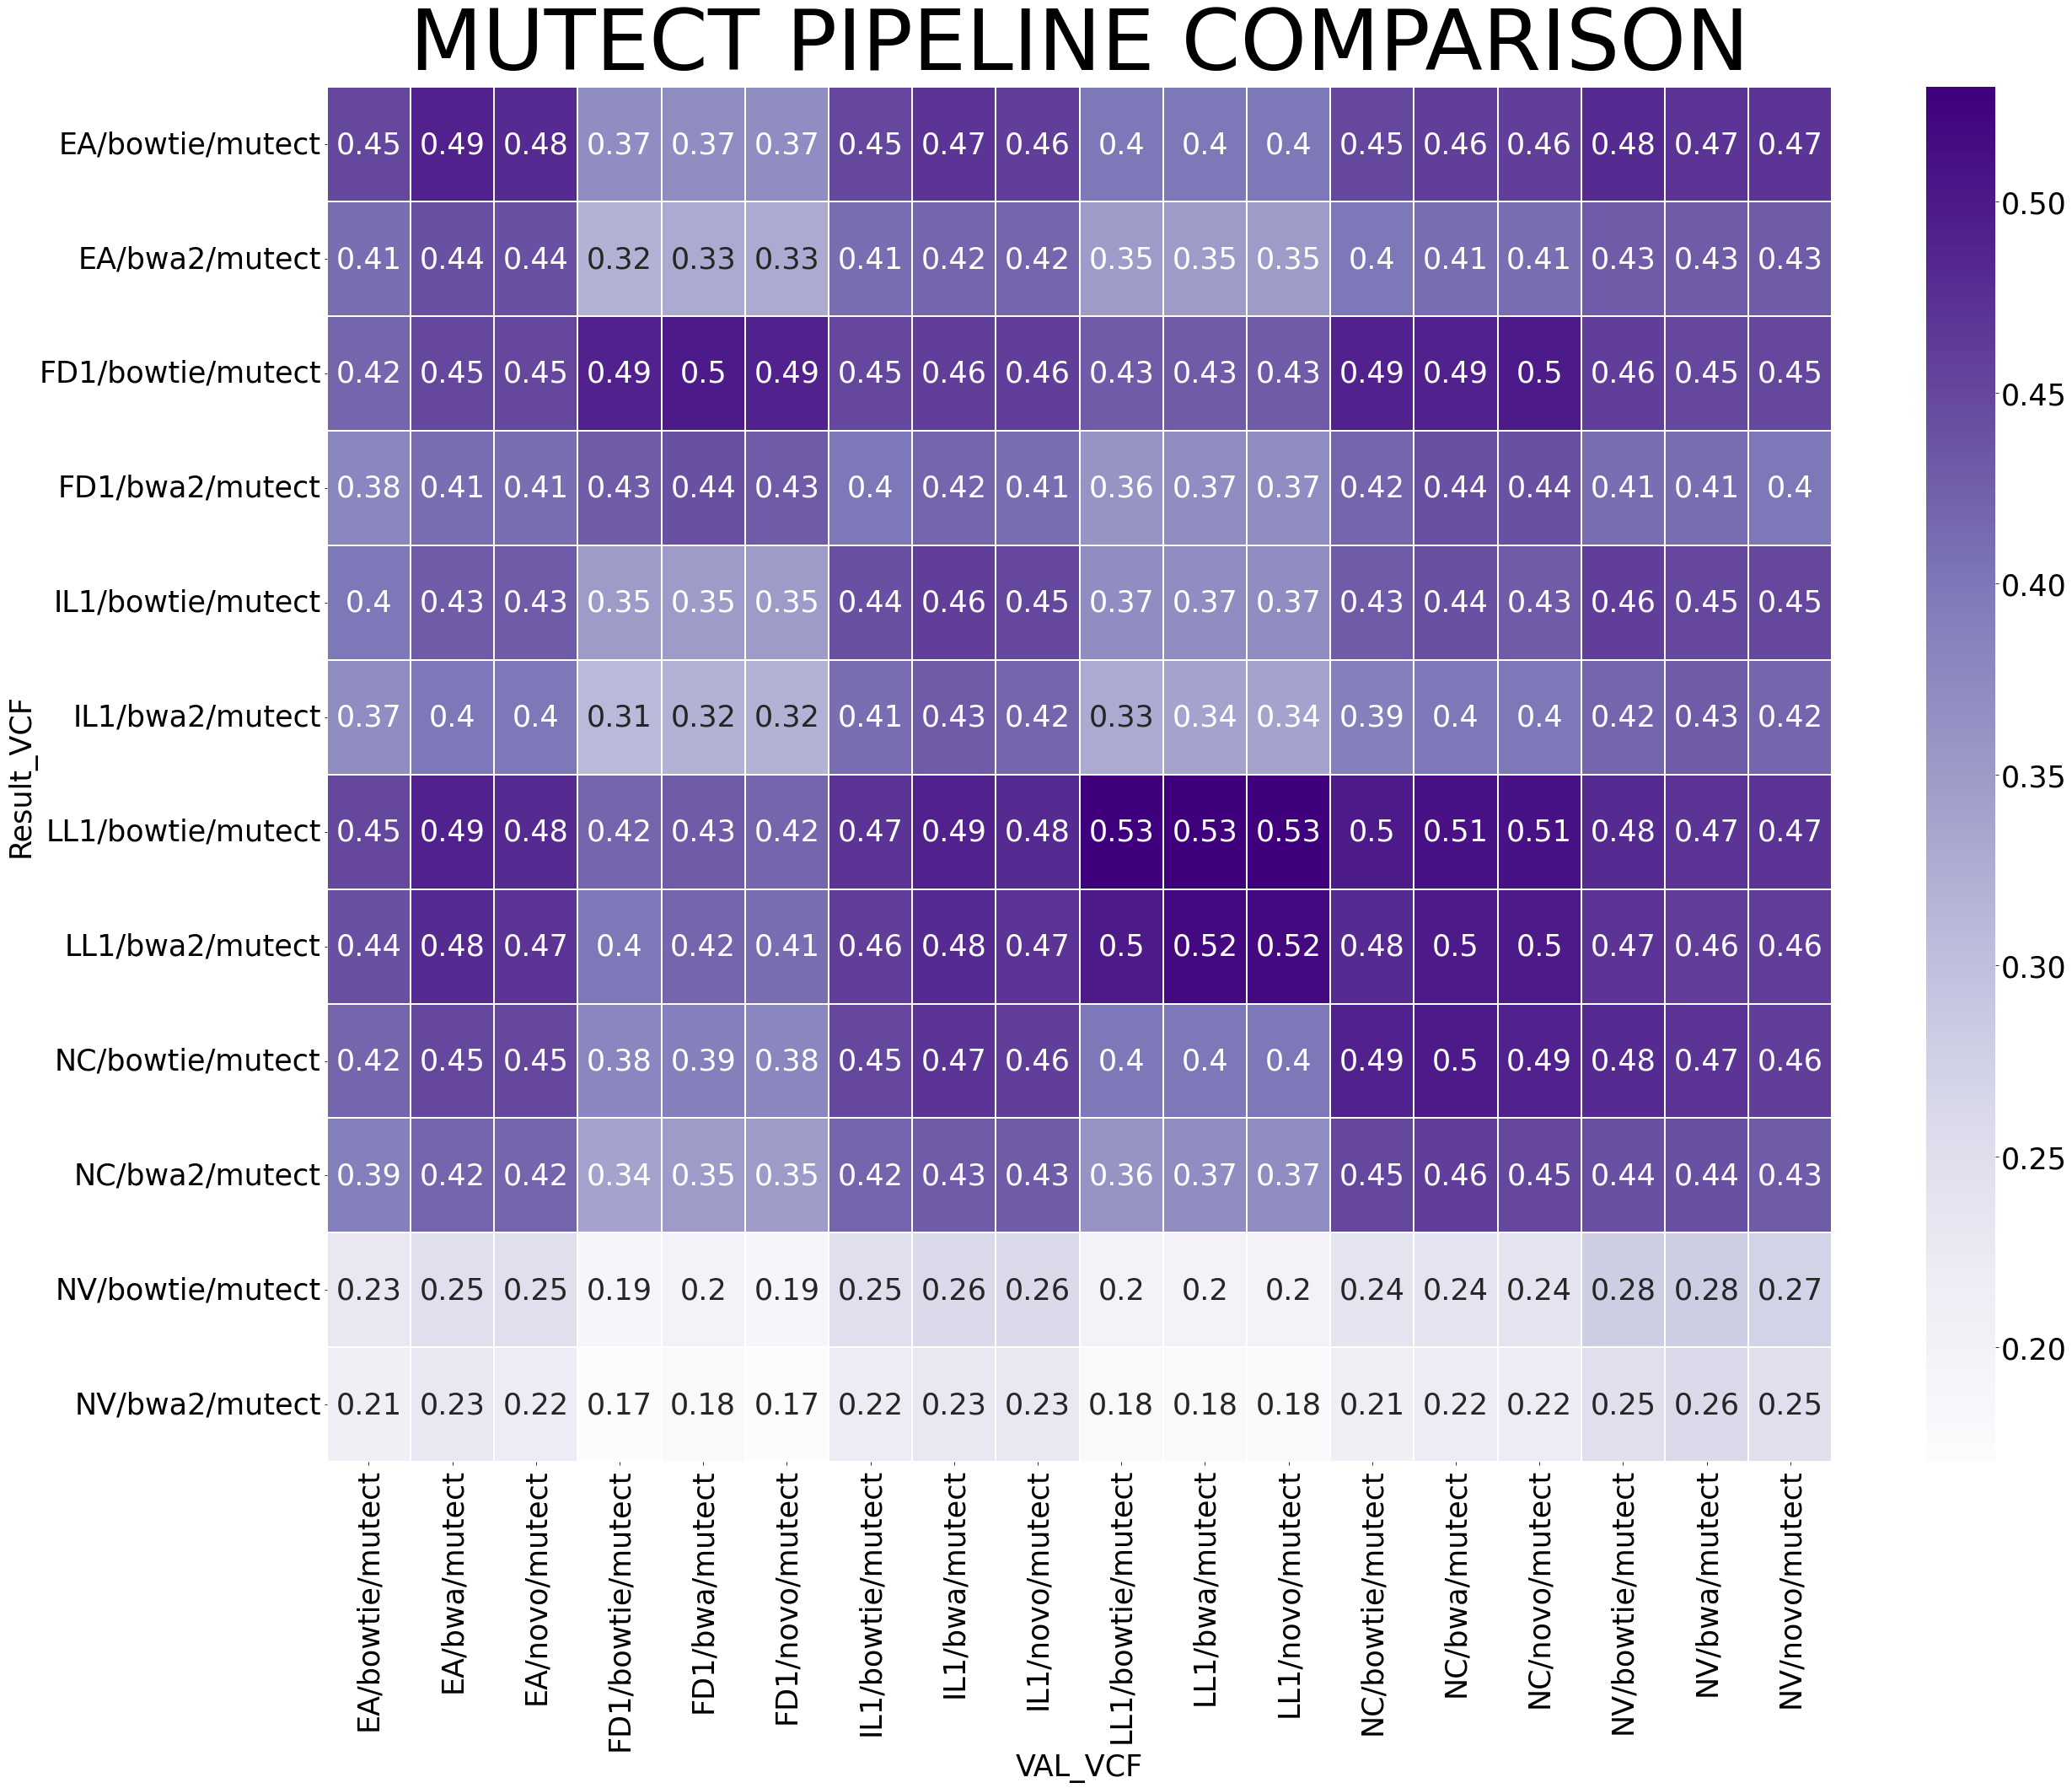

In [29]:
### mutect
plt.figure(figsize = (40,30))
plt.title('MUTECT PIPELINE COMPARISON', size = 100)
t_mutect_h = df_mutect.pivot("Result_VCF", "VAL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(t_mutect_h, annot=True, cmap="Purples", linewidths=.2)

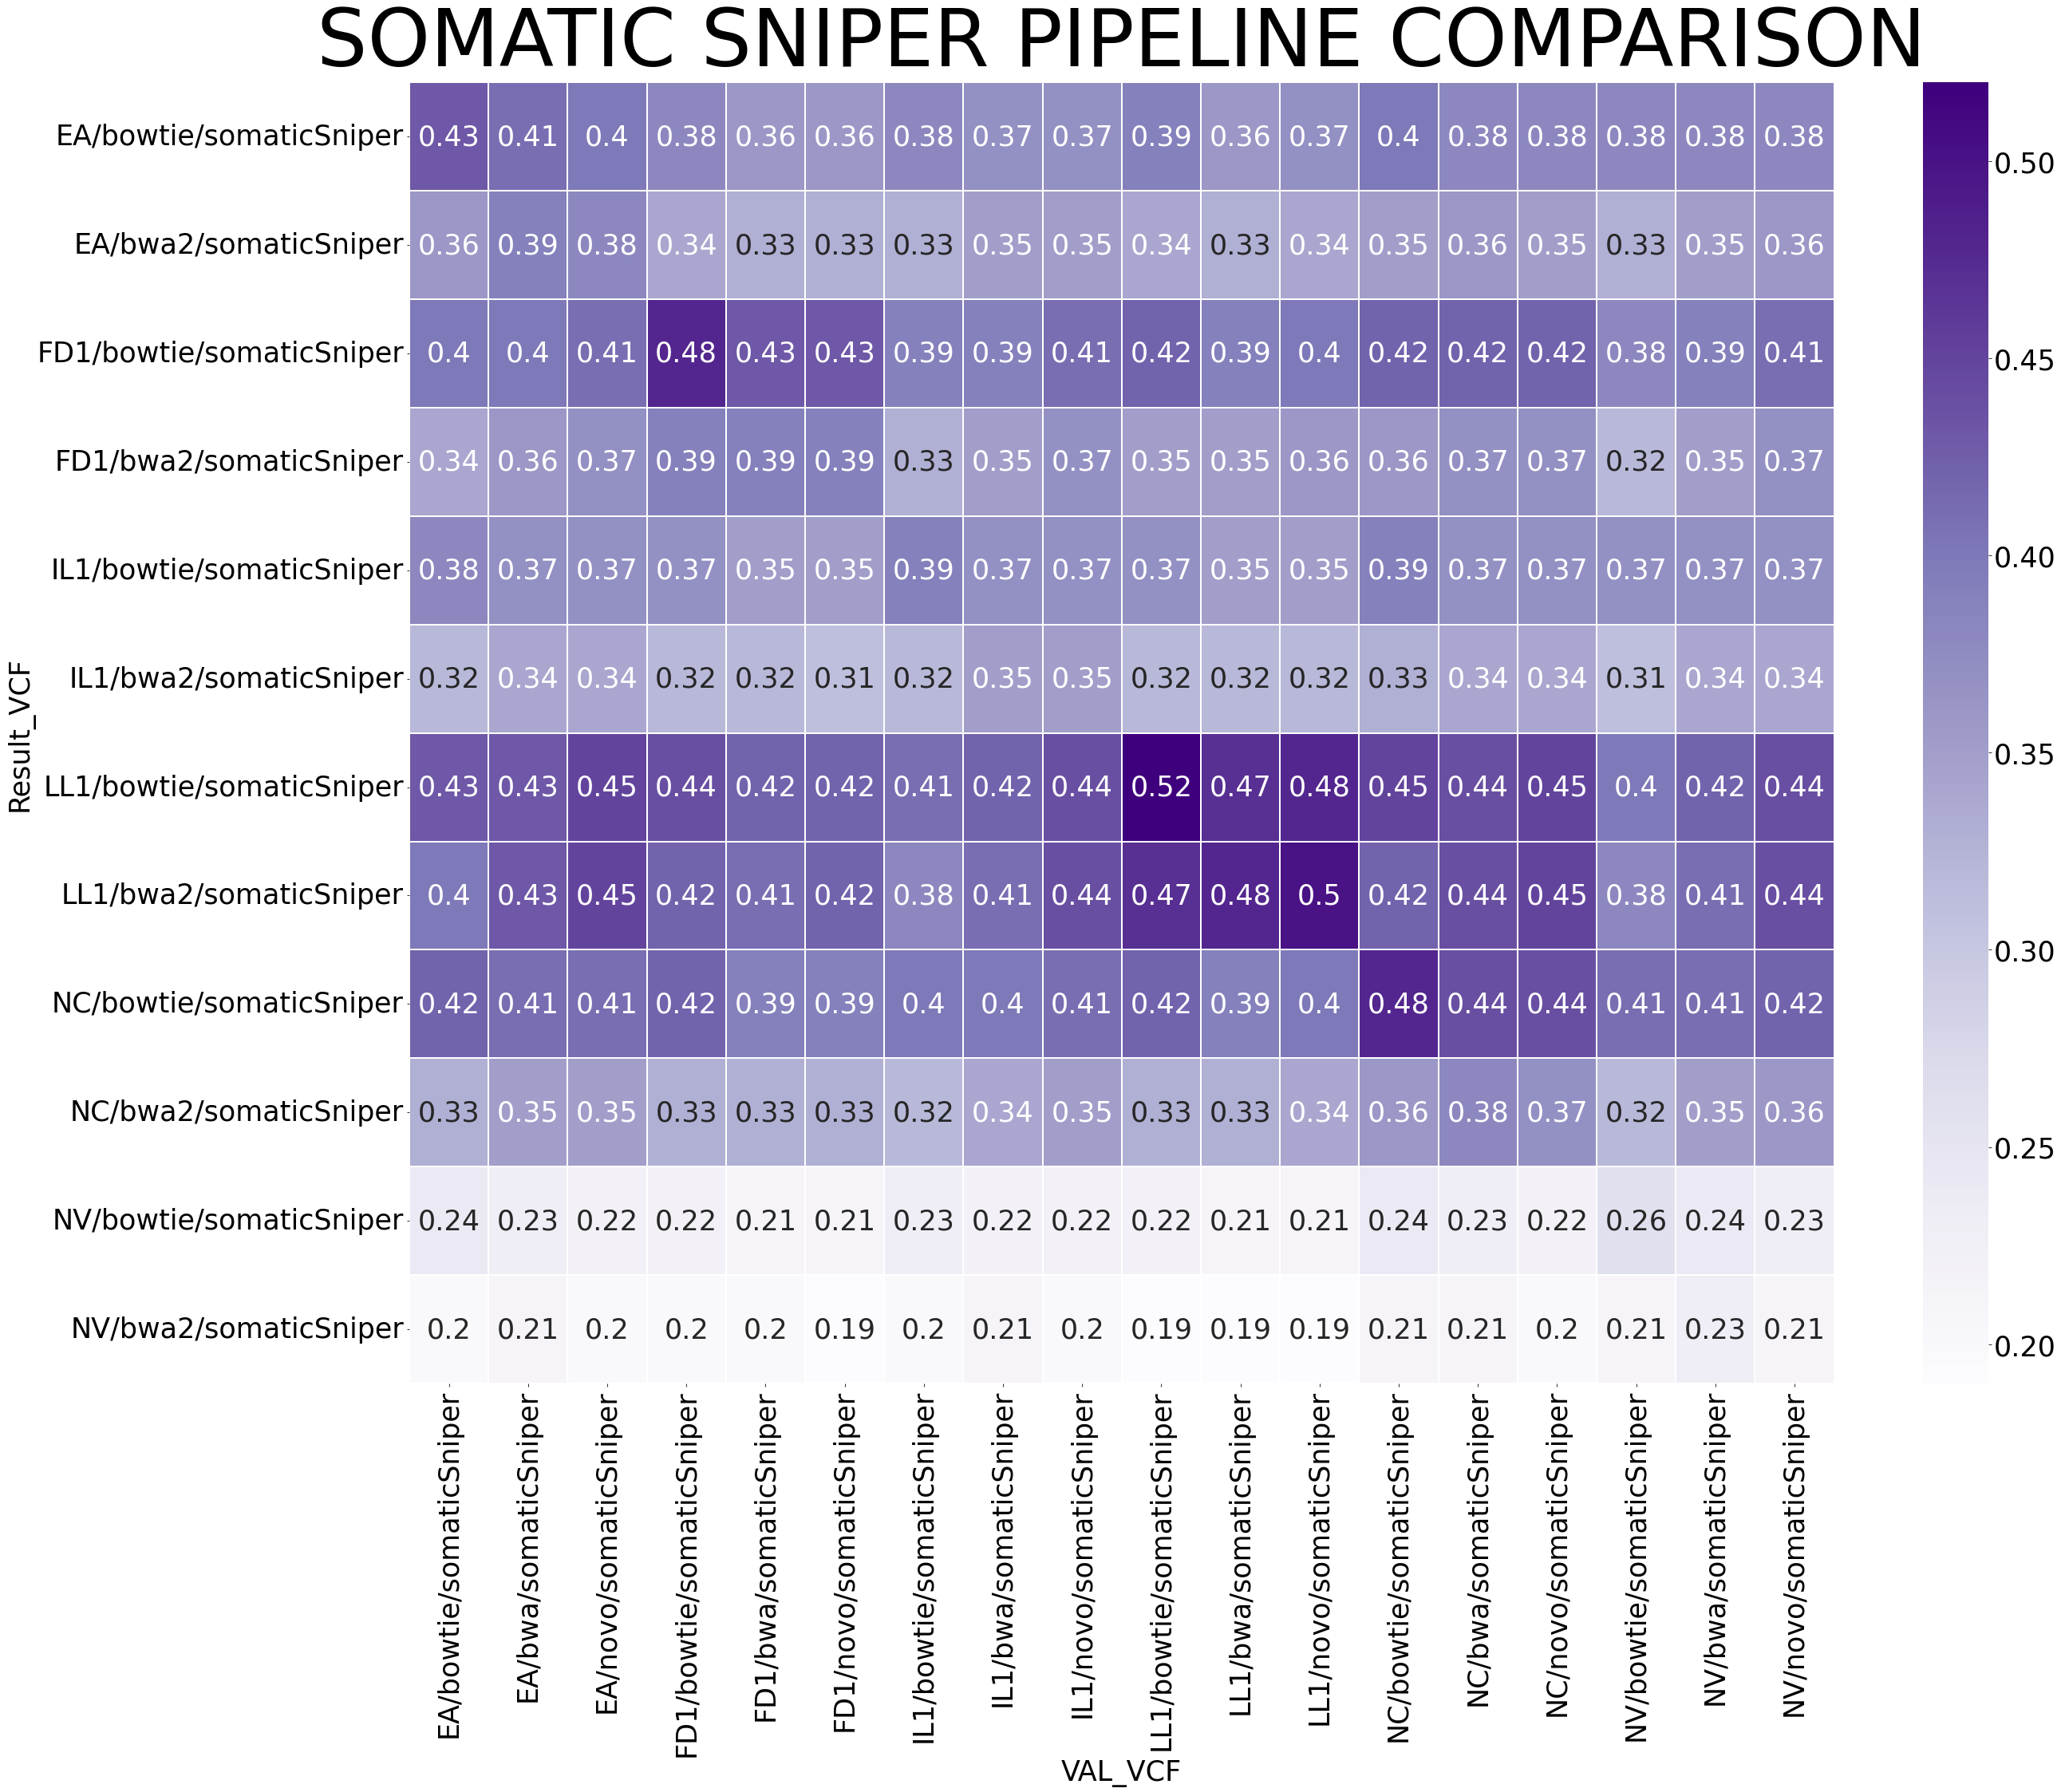

In [31]:
### somaticSniper
plt.figure(figsize = (40,30))
plt.title('SOMATIC SNIPER PIPELINE COMPARISON', size = 100)
t_ss_h = df_ss.pivot("Result_VCF", "VAL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(t_ss_h, annot=True, cmap="Purples", linewidths=.2)

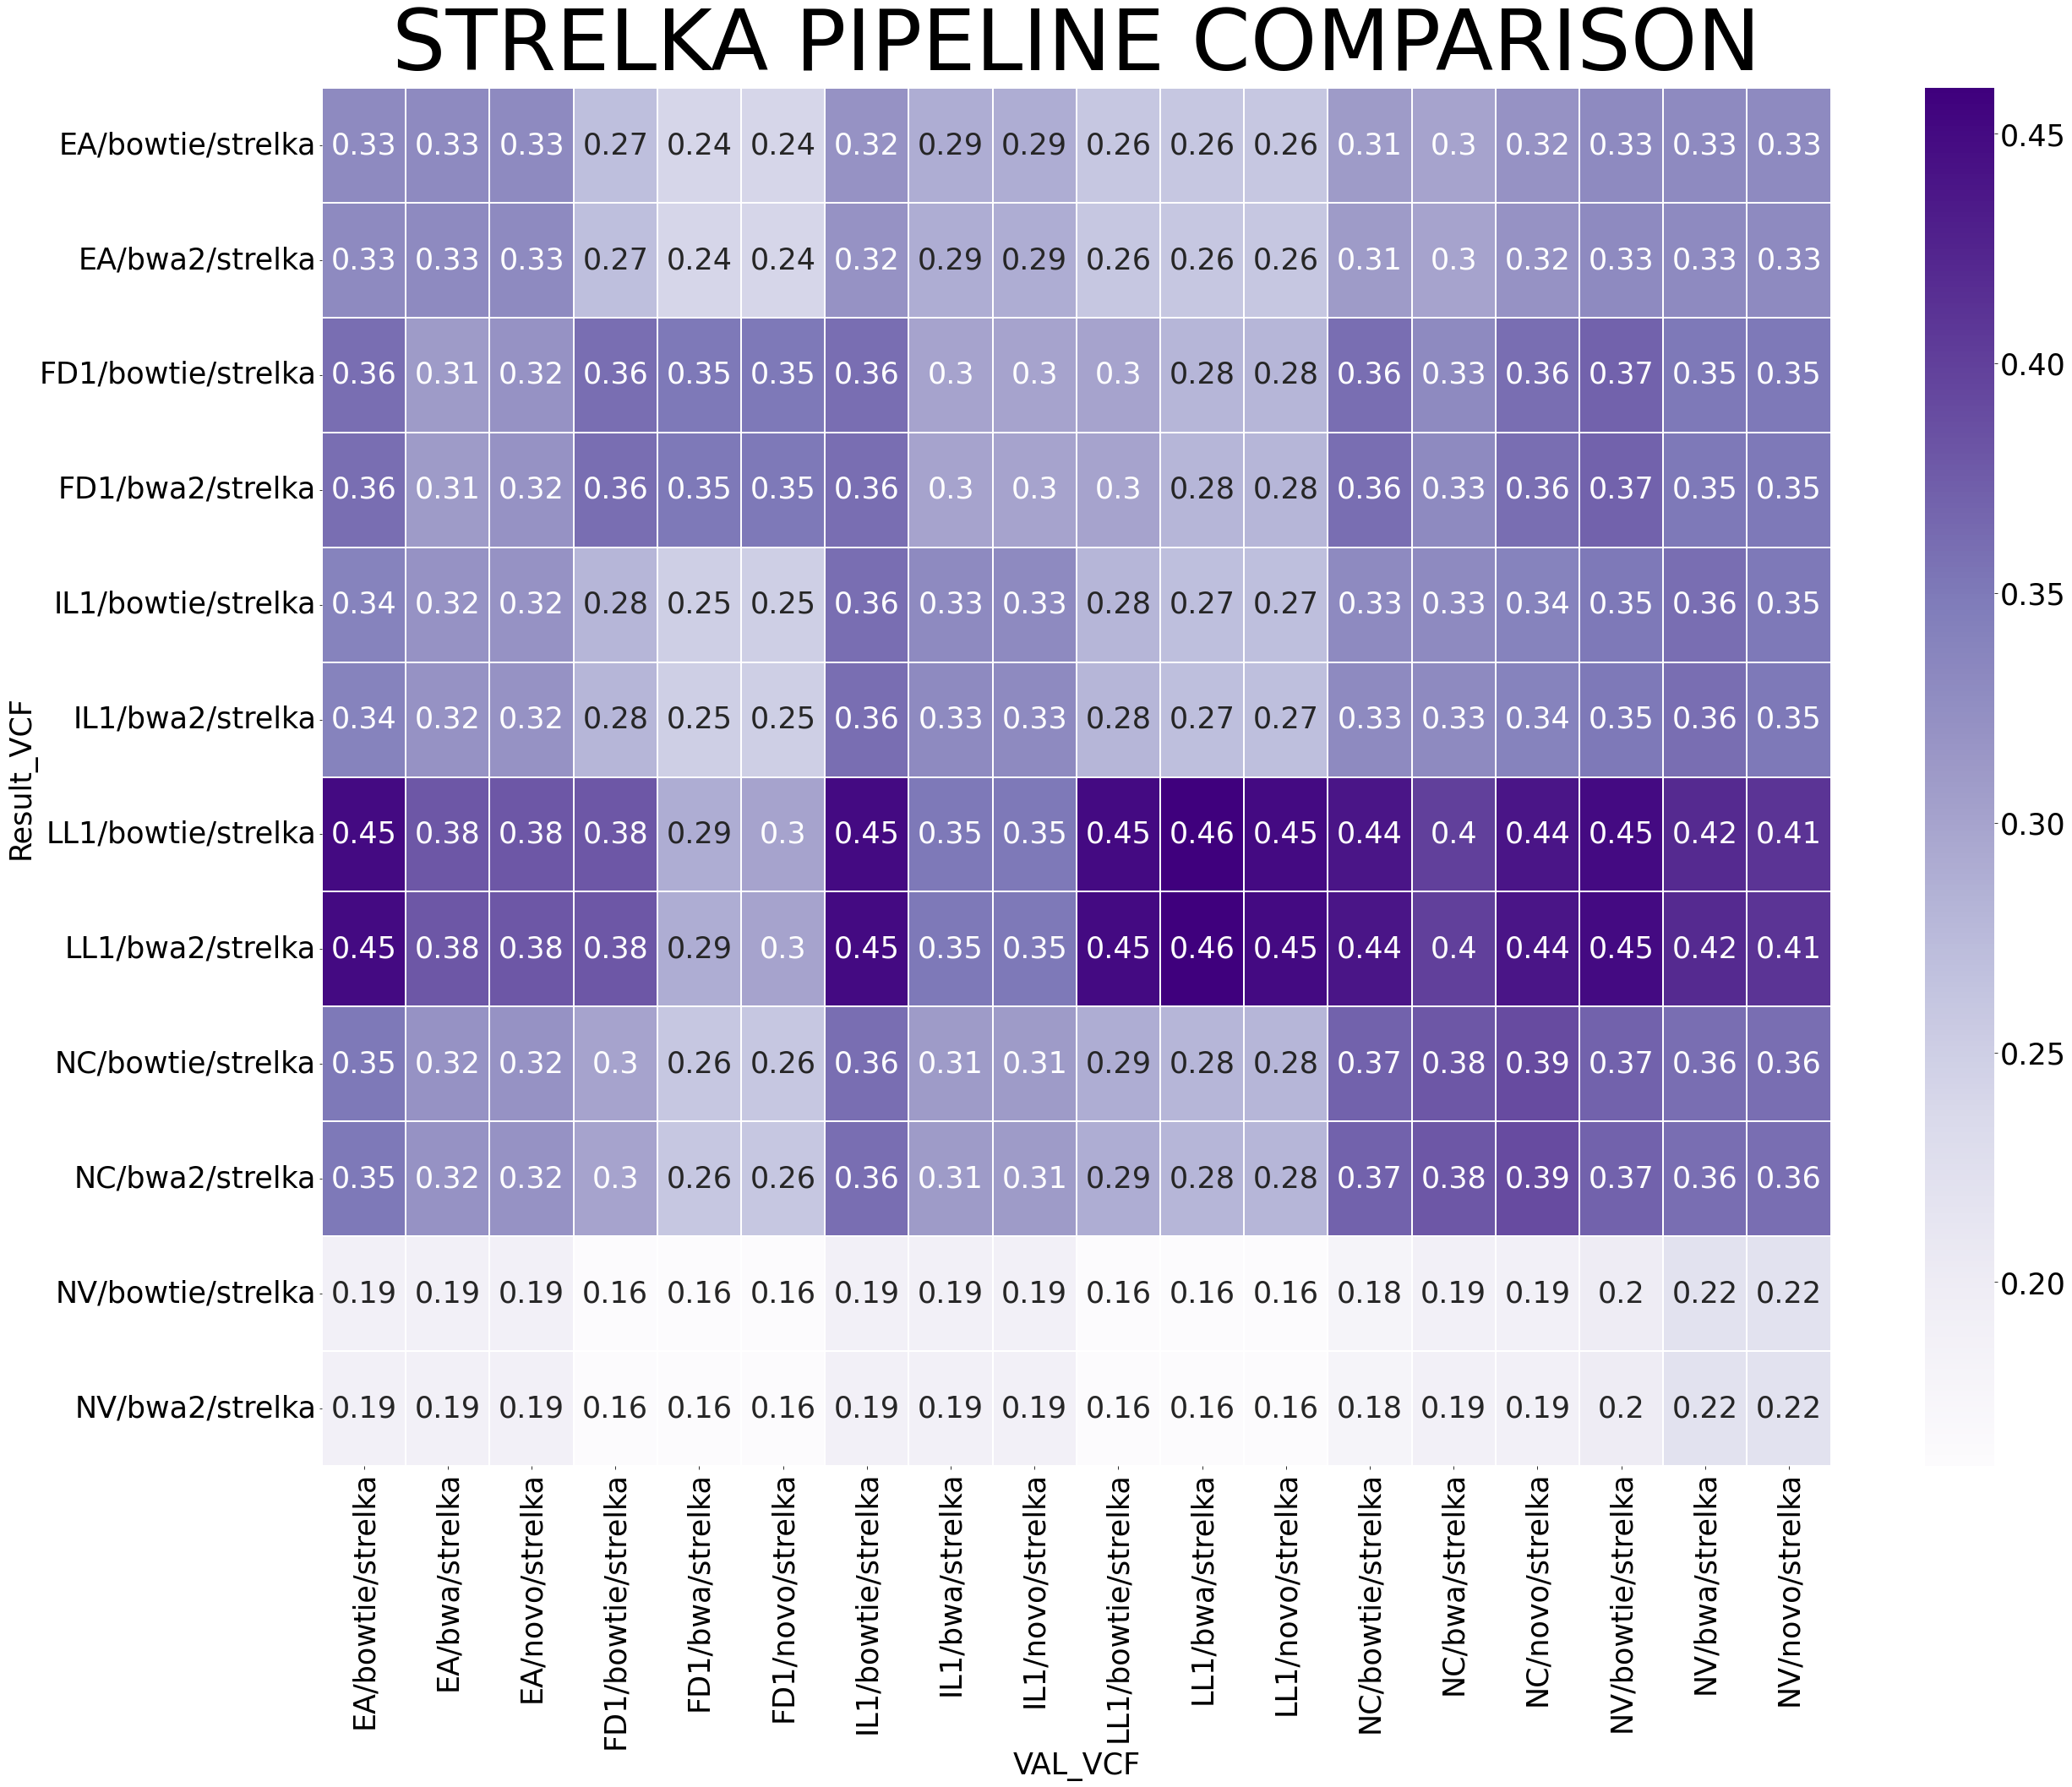

In [32]:
### strelka
plt.figure(figsize = (40,30))
plt.title('STRELKA PIPELINE COMPARISON', size = 100)
t_strelka_h = df_strelka.pivot("Result_VCF", "VAL_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(t_strelka_h, annot=True, cmap="Purples", linewidths=.2)

## PART D) COMPARISON WITH UNION VALIDATED VCF'S

### 1- Create an union of all ll validated vfc sets for each data

In [15]:
union_v_vcf = {}
for key, value in ll_sets_dict.items():
    union_v_vcf[key[:len(key.split('/')[0])]] = union_v_vcf.get(key[:len(key.split('/')[0])], set()) | value

In [16]:
#Initializing a dataframe
df_union = pd.DataFrame(columns=["V_VCF", "Result_VCF", "Results", 'length'])

#Initializing a count for the rows
count = 0

#Computing each intersection of ll and the pipeline vcfs by looking at their key values. 
for key1 in sets_dict:
    df_union[count] = [((key1.split('/')[0]).split('(')[0]).upper(), key1, js_set(union_v_vcf[((key1.split('/')[0]).split('(')[0]).upper()],sets_dict[key1]),len(union_v_vcf[((key1.split('/')[0]).split('(')[0]).upper()]) ]
    count += 1

#Taking transpose of the df and, getting rid of the first three rows then renaming axis again.
df_union = df_union.transpose().iloc[4: , :].set_axis(['V_VCF', 'Result_VCF', 'Results', 'length'], axis=1, inplace=False)

#df_union

### 2- Show results in heatmap

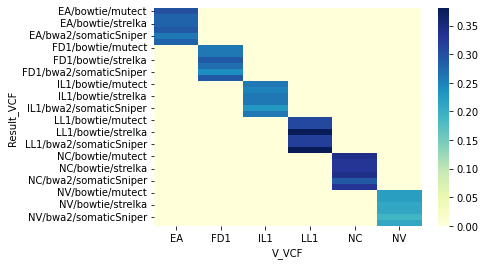

In [17]:
df_union_h = df_union.pivot("Result_VCF", "V_VCF", "Results").fillna(0).apply(pd.to_numeric)
ax = sns.heatmap(df_union_h, annot=False,cmap="YlGnBu")

## PART E) OPENCRAVAT DATA

### 1 - read results from https://run.opencravat.org/submit/nocache/index.html for pipeline

In [30]:
oc_filenames = {}
for root, directories, filenames in os.walk('vcf/openCravat/pipeline'):
    for fn in filenames:
        if fn == '.DS_Store':
            continue;
        else:
            oc_filenames[fn.split('.')[0]] = os.path.join(root,fn)

In [31]:
oc_dict = {}
oc_geneDict = {}

for key in tqdm(oc_filenames):
    
    temp = pd.read_csv(oc_filenames[key], delimiter= '\t', skiprows = 6)
    oc_dict[key]= list(temp['Sequence_Ontology'])
    oc_geneDict[key]= list(temp['Gene'])

 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.02it/s]/Users/P33833/miniconda3/envs/mywork1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.16it/s]


### 2 - Show Sequence_Ontology for each pipeline data

In [32]:
oc_results = pd.DataFrame(columns=["KEY", "Sequence_Ontology", "Count"])
for key in oc_dict:
    values, counts = np.unique(oc_dict[key], return_counts=True)
    for x in range(len(values)):
        oc_results.loc[len(oc_results.index)] = [key,values[x],counts[x]]

In [33]:
pd.set_option('display.max_rows', oc_results.shape[0]+1)
oc_results = oc_results.sort_values(by=['Count'])

#print(oc_results)

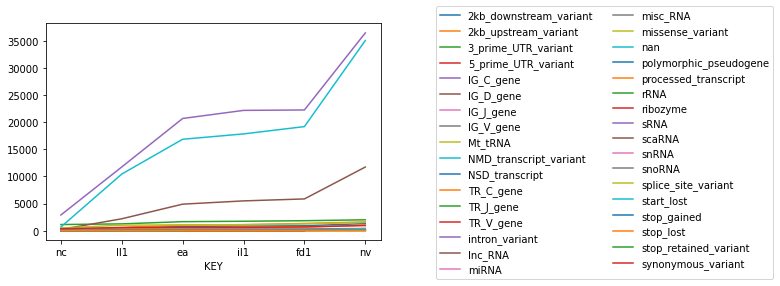

In [68]:
oc_df = oc_results.copy()
oc_df.set_index('KEY', inplace=True)
oc_df = oc_df.sort_values(by=['Count'])
oc_df.groupby('Sequence_Ontology')['Count'].plot()
#plt.legend(loc=(-1, -1))
plt.legend(bbox_to_anchor =(1.15, 1.10), ncol = 2)

In [283]:
oc_df = oc_results.copy()
import plotly.express as px
fig = px.histogram(oc_df, x="KEY", y="Count",
             color='Sequence_Ontology', barmode='group',
             height=400, title='Sequence_Ontology Results on Pipeline Results')
fig.update_xaxes(categoryorder='category ascending')
fig.show()

### 3 - read results from https://run.opencravat.org/submit/nocache/index.html for validated vcfs

In [35]:
oc_v_filenames = {}
for root, directories, filenames in os.walk('vcf/openCravat/validated'):
    for fn in filenames:
        if fn == '.DS_Store':
            continue;
        else:
            oc_v_filenames[fn.split('.')[0]] = os.path.join(root,fn)

In [36]:
oc_v_dict = {}
oc_v_geneDict = {}

for key in tqdm(oc_v_filenames):
    
    temp = pd.read_csv(oc_v_filenames[key], delimiter= '\t', skiprows = 6)
    oc_v_dict[key] = list(temp['Sequence_Ontology'])
    oc_v_geneDict[key] = list(temp['Gene'])

 33%|███████████████                              | 2/6 [00:00<00:00,  9.66it/s]/Users/P33833/miniconda3/envs/mywork1/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (22,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.64it/s]


### 4 - Show Sequence_Ontology for each validated data

In [37]:
oc_v_results = pd.DataFrame(columns=["KEY", "Sequence_Ontology", "Count"])
for key in oc_v_dict:
    values, counts = np.unique(oc_v_dict[key], return_counts=True)
    for x in range(len(values)):
        oc_v_results.loc[len(oc_v_results.index)] = [key,values[x],counts[x]]

In [106]:
oc_results.tail()

KEY Sequence_Ontology  Count
36   fd1    intron_variant  20685
65   il1    intron_variant  22178
93    ea    intron_variant  22255
159   nc               nan  35059
154   nc    intron_variant  36468

In [38]:
pd.set_option('display.max_rows', oc_v_results.shape[0]+1)
oc_v_results = oc_v_results.sort_values(by=['Count'])

#print(oc_v_results)

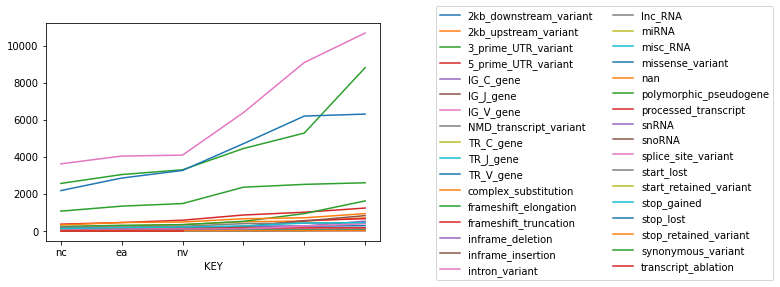

In [39]:
oc_v_df = oc_v_results.copy()
oc_v_df.set_index('KEY', inplace=True)
oc_v_df = oc_v_df.sort_values(by=['Count'])
oc_v_df.groupby('Sequence_Ontology')['Count'].plot()
plt.legend(bbox_to_anchor =(1.15, 1.10), ncol = 2)

In [281]:
oc_v_df = oc_v_results.copy()
import plotly.express as px
fig = px.histogram(oc_v_df, x="KEY", y="Count",
             color='Sequence_Ontology', barmode='group',
             height=400, title='Sequence_Ontology Results on Validated Results')
fig.update_xaxes(categoryorder='category ascending')
fig.show()

### GENE FOR PIPELINE

In [40]:
oc_geneResults = pd.DataFrame(columns=["KEY", "Gene", "Count"])
for key in tqdm(oc_geneDict):
    values, counts = np.unique(oc_geneDict[key], return_counts=True)
    for x in range(len(values)):
        oc_geneResults.loc[len(oc_geneResults.index)] = [key,values[x],counts[x]]

100%|█████████████████████████████████████████████| 6/6 [05:01<00:00, 50.22s/it]


In [109]:
pd.set_option('display.max_rows', oc_geneResults.shape[0]+1)
df_p = oc_geneResults.copy().reset_index(drop=True) 

### GENE FOR VALIDATED

In [93]:
oc_v_geneResults = pd.DataFrame(columns=["KEY", "Gene", "Count"])
for key in tqdm(oc_v_geneDict):
    values, counts = np.unique(oc_v_geneDict[key], return_counts=True)
    for x in range(len(values)):
        oc_v_geneResults.loc[len(oc_v_geneResults.index)] = [key,values[x],counts[x]]

100%|█████████████████████████████████████████████| 6/6 [02:33<00:00, 25.57s/it]


In [110]:
pd.set_option('display.max_rows', oc_v_geneResults.shape[0]+1)
df_v = oc_v_geneResults.copy()

### GENE COMPARISON

In [112]:
df_p["type"] = "pipeline"
df_v["type"] = "validation"

df = pd.concat([df_p, df_v]).reset_index(drop=True)

df = df.dropna(subset=["Gene"]).reset_index(drop=True)

df = df.rename(columns={
    "KEY": "dataset",
    "Gene": "gene",
    "Count": "count"
})

df = df[df["count"] > 5].reset_index(drop=True)


In [284]:
for dataset, frame in df.groupby("dataset"):
    genes = frame["gene"][frame["gene"].duplicated()]
    frame = frame[frame["gene"].isin(set(genes))]
    fig = px.bar(frame, x="gene", y="count", color="type", title=dataset) 
    fig.update_layout(barmode='group', xaxis={'categoryorder':'total descending'})
    fig.show()

In [114]:
for dataset, frame in df.groupby("dataset"):
    break

In [115]:
f1 = df[df["type"] == "pipeline"].set_index(["dataset", "gene"])
f1.columns += "_1"

In [116]:
f2 = df[df["type"] == "validation"].set_index(["dataset", "gene"])
f2.columns += "_2"

In [117]:
f = pd.concat([f1, f2], axis=1)

In [118]:
f["delta"] = f["count_1"] - f["count_2"]

In [142]:
f = f.dropna(subset=["delta"])
f = f.dropna(subset=["gene"])

In [147]:
f["abs_delta"] = f["delta"].apply(abs)
f

count_1    type_1 count_2      type_2  delta  \
dataset gene                                                                  
ea      ABCA13                      10  pipeline       8  validation      2   
        ABCA4                        7  pipeline      11  validation     -4   
        ABCC11                      24  pipeline      13  validation     11   
        AC005747.1                   9  pipeline       6  validation      3   
        AC009022.1                  16  pipeline       6  validation     10   
        AC139099.2                   7  pipeline      20  validation    -13   
        ADAD2                        9  pipeline       9  validation      0   
        ADAMTS17                    12  pipeline       6  validation      6   
        ADCY1                       15  pipeline       6  validation      9   
        ADGRB1                      13  pipeline      13  validation      0   
        ADGRE2                      10  pipeline       6  validation      4   
        ADGRG1                      14  pipeline       9  validation      5   
        ADGRG5                       9  pipeline       9  validation      0   
        AF241726.2                  14  pipeline      12  validation      2   
        AGAP1                        8  pipeline      12  validation     -4   
        AHNAK                        8  pipeline       6  validation      2   
        AHRR                        13  pipeline       9  validation      4   
        AL133268.4                   6  pipeline       7  validation     -1   
        ALDH5A1                      9  pipeline       8  validation      1   
        ALG6                         7  pipeline       6  validation      1   
        ALK                         14  pipeline       8  validation      6   
        ALMS1                        6  pipeline      11  validation     -5   
        ALPP                         7  pipeline      13  validation     -6   
        ANK3                        10  pipeline       6  validation      4   
        ANKRD36C                    11  pipeline       7  validation      4   
        ANKS1A                      10  pipeline       9  validation      1   
        ANO1                         6  pipeline      13  validation     -7   
        ARHGAP42                    11  pipeline       7  validation      4   
        ARHGEF3                      7  pipeline       7  validation      0   
        ASH1L                        6  pipeline       7  validation     -1   
        ASMTL                       24  pipeline       8  validation     16   
        ATG5                         6  pipeline       6  validation      0   
        ATP11A                       7  pipeline       8  validation     -1   
        ATP2C2                      15  pipeline      14  validation      1   
        ATR                          8  pipeline      10  validation     -2   
        ATXN1                       14  pipeline      11  validation      3   
        AXDND1                      15  pipeline       6  validation      9   
        BAHCC1                      14  pipeline      20  validation     -6   
        BBS2                        13  pipeline       9  validation      4   
        BCO1                        16  pipeline       8  validation      8   
        BLOC1S5                      6  pipeline       6  validation      0   
        BTN1A1                       8  pipeline      11  validation     -3   
        C4orf50                     11  pipeline       6  validation      5   
        C6orf132                    21  pipeline      11  validation     10   
        CACNA1A                     29  pipeline      12  validation     17   
        CACNA1D                      7  pipeline       8  validation     -1   
        CACNA1I                     11  pipeline      10  validation      1   
        CADPS                        7  pipeline       7  validation      0   
        CASZ1                        7  pipeline       9  validation     -2   
  

In [145]:
f  = f.set_index(["dataset", "gene"])

In [150]:
fig = px.bar(f[f["abs_delta"] > 10].reset_index().sort_values("abs_delta", ascending=False).head(50), x="gene", y="delta", color="dataset", title="pipeline - validation")
fig.update_layout(barmode='group', xaxis={'categoryorder':'total descending'})
fig.show()